In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  
plt.rcParams.update({'figure.figsize': (8,6)})

import seaborn as sns
from sklearn.cluster import DBSCAN


import hdbscan
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
plt.style.use('default')

In [2]:
conn = sqlite3.connect('IowaLiquor.db')
sales = pd.read_sql_query(
    "SELECT I.ItemNumber, P.ItemDescription, Date, Sale, BottlesSold, Proof, Age, I.StoreNumber, StoreName, "
        "P.CategoryName, I.BottleVolume, I.VendorNumber, VendorName, Latitude, Longitude, County "
    "FROM Invoice as I "
    "INNER JOIN Item as P on I.ItemNumber=P.ItemNumber "
    "and I.BottleVolume=P.BottleVolume "
    "and I.VendorNumber=P.VendorNumber "
    "INNER JOIN store as S on I.StoreNumber=S.StoreNumber "
    "WHERE S.StoreName Like '%Hy-Vee%'", conn)
sales.to_csv('hy-vee.csv')

# Import Hy-Vee Sales Data

In [3]:
sales = pd.read_csv('hy-vee.csv')
sales.drop(columns='Unnamed: 0', inplace=True)
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y', errors='ignore')
sales.index = sales.Date

Check store names to assign store type:
- General Store
- Food Store
- Food & Drugstore
- Wine & Spirits
- Drugstore

In [4]:
storenames = [re.sub(' \d|\d','', i) for i in sales['StoreName'].unique()]
set(storenames)

# Create store type
sales['StoreType'] = 'General Store'
sales.loc[sales.StoreName.str.contains('Food Store'), 'StoreType'] = 'Food Store'
sales.loc[sales.StoreName.str.contains('Wine & Spirits'), 'StoreType'] = 'Wine & Spirits'
sales.loc[sales.StoreName.str.contains('Food & Drug'), 'StoreType'] = 'Food & Drugstore'
sales.loc[sales.StoreName=='Drugstore', 'StoreType'] = 'Drugstore'

# High-Level Analysis
- Gain insights into stores
    - Sales
    - Number of Stores over time
    - Average store life
    - Average sales/store
    - Separate by store type
- Gain insights into products
    - Number of new products
    - Different product categories
    - Which ones are the most popular?
    - Separate by product categories

### Total number of stores over time

- Very strange that the number of stores seems to skyrocket in 2019

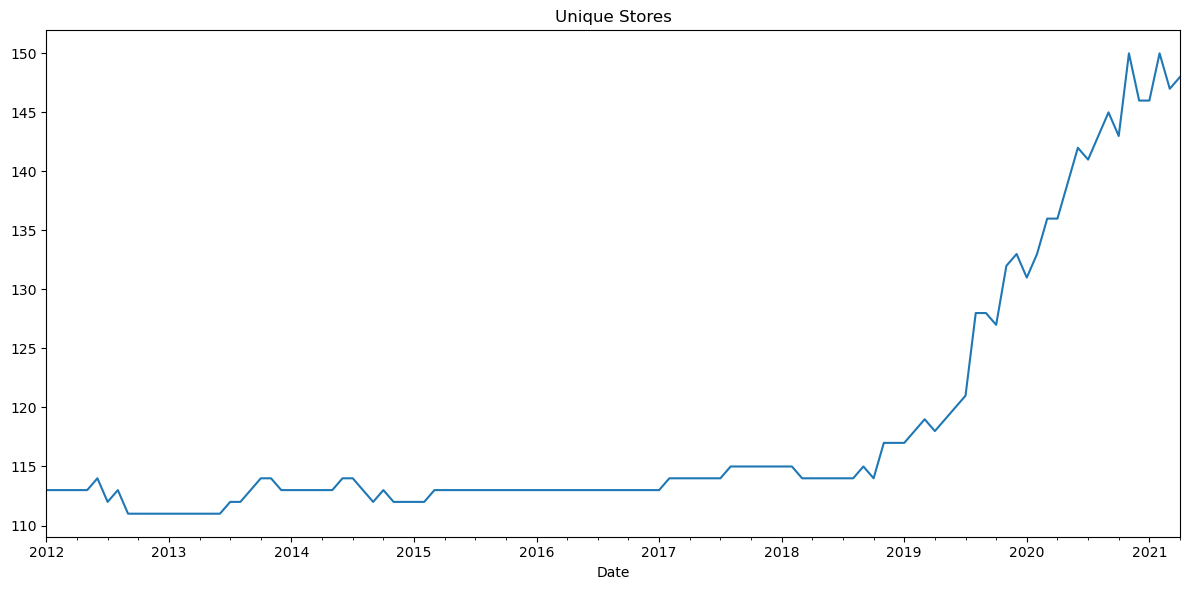

In [5]:
totalStores = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalStores = totalStores.reset_index('Date').pivot_table(index='StoreNumber', columns='Date', aggfunc=np.sum)
totalStores.columns = totalStores.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalStores.count().plot()
ax.set_title('Unique Stores')
f.tight_layout()

### Now separately by store type
- Increase came from the establishment of new general stores

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:6822: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return pivot_table(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


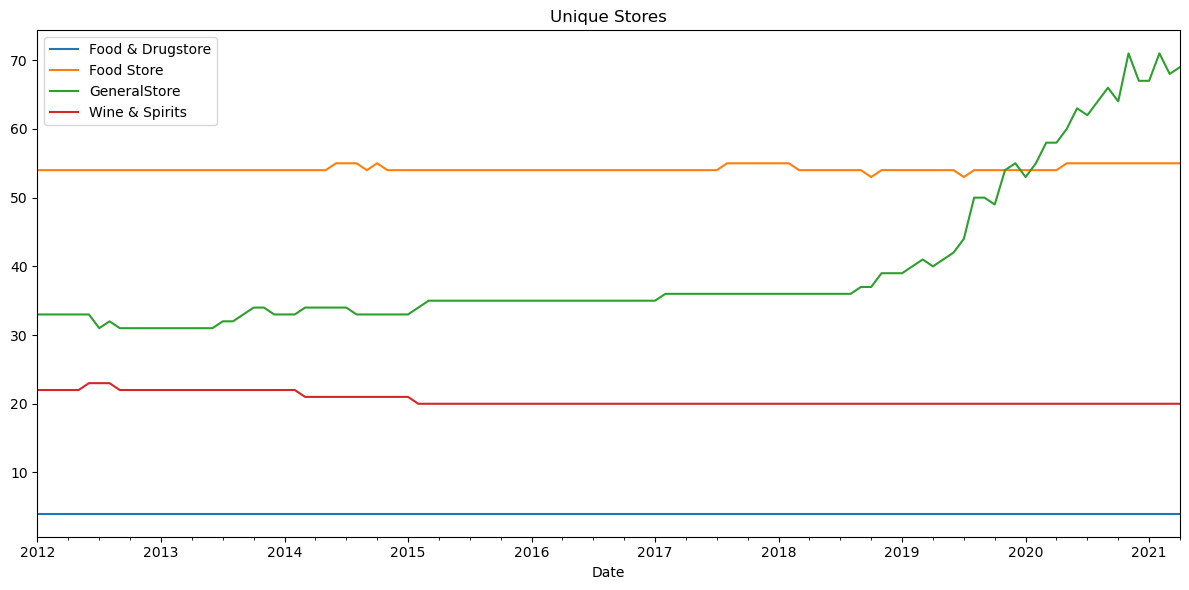

In [6]:
totalStores = sales.groupby(['StoreType', 'StoreNumber', pd.Grouper(key='Date', freq='M')]).agg({'Sale':['sum']})
totalStores = totalStores.reset_index('Date').pivot_table(index='Date', columns='StoreType', aggfunc='count')
totalStores.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']

f,ax = plt.subplots(figsize = (12,6))
totalStores.plot(ax=ax)
ax.set_title('Unique Stores', fontsize=12)
f.tight_layout()

### Mean Store Life
- Examine average survival rate of stores overall and by store stype

<AxesSubplot:ylabel='Frequency'>

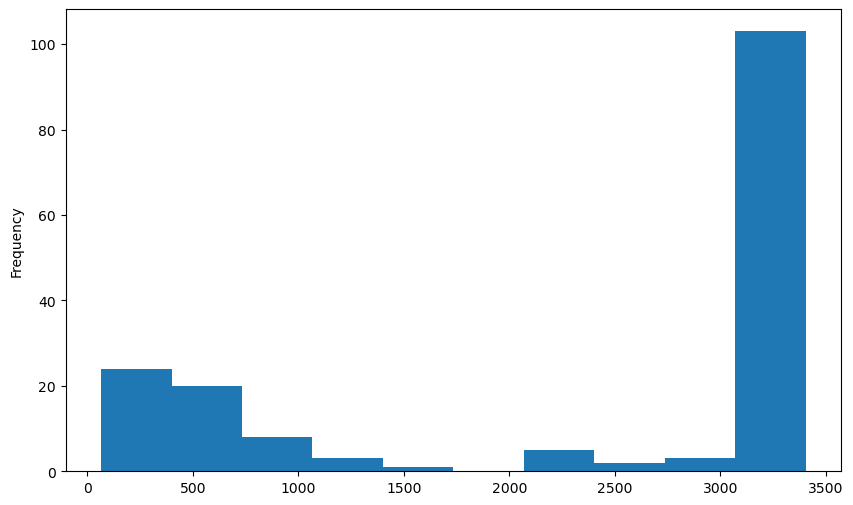

In [7]:
storeLife = sales.groupby(['StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'].dt.days.plot(kind='hist', figsize=(10,6))

<AxesSubplot:ylabel='Frequency'>

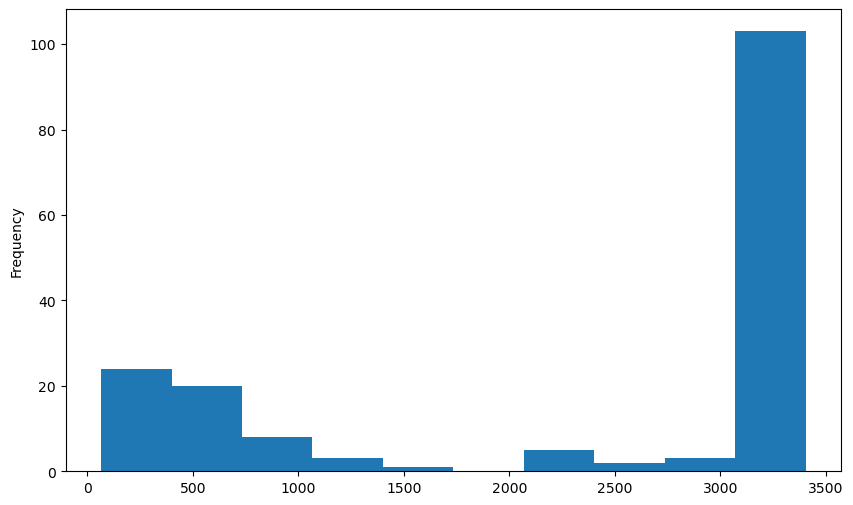

In [8]:
storeLife = sales.groupby(['StoreType','StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'].dt.days.plot(kind='hist', figsize=(10,6))

Confirms that general stores are usually younger.

<AxesSubplot:ylabel='StoreType'>

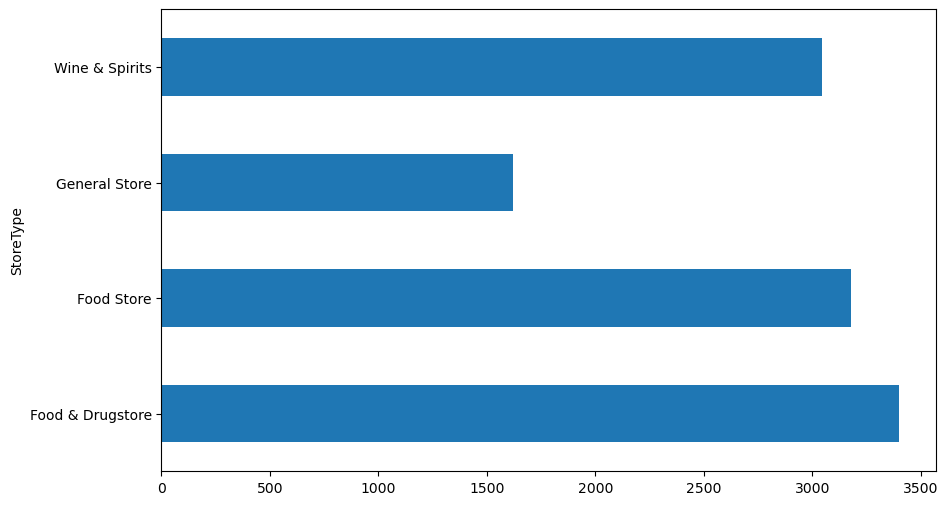

In [9]:
storeLife = sales.groupby(['StoreType','StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'] = storeLife['SurvivalDuration'].dt.days
storeLife = storeLife.groupby('StoreType').agg(SurvivalDuration = ('SurvivalDuration','mean'))
storeLife['SurvivalDuration'].plot(kind='barh', figsize=(10,6))

### Sales per store

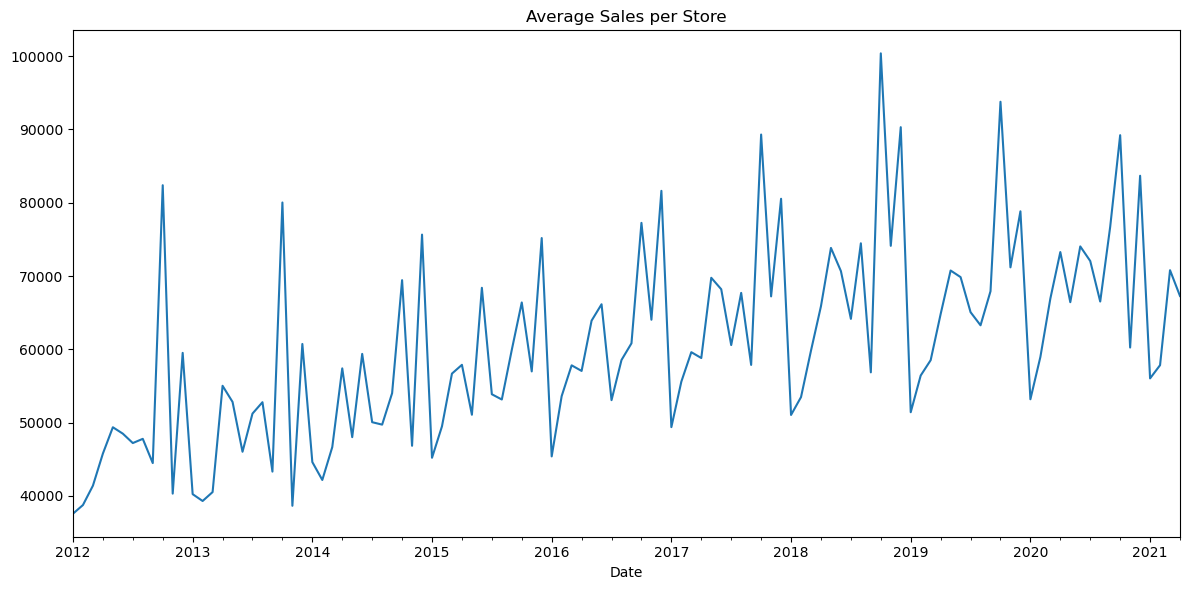

In [10]:
totalStores = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalSales = totalStores.reset_index().groupby('Date').agg(Sale=('Sale','sum'))

totalStores = totalStores.reset_index().groupby('Date').agg(Stores=('StoreNumber', 'count'))
avg_sales_per_store = totalSales.Sale/totalStores.Stores
f,ax = plt.subplots(figsize = (12,6))
pd.DataFrame(avg_sales_per_store,index=totalStores.index).plot(ax=ax, legend=None)
ax.set_title('Average Sales per Store')
f.tight_layout()

Seems likes the number of general stores is increasing faster than sales growth. This can be seen in the decrease in averaqge sales per store.

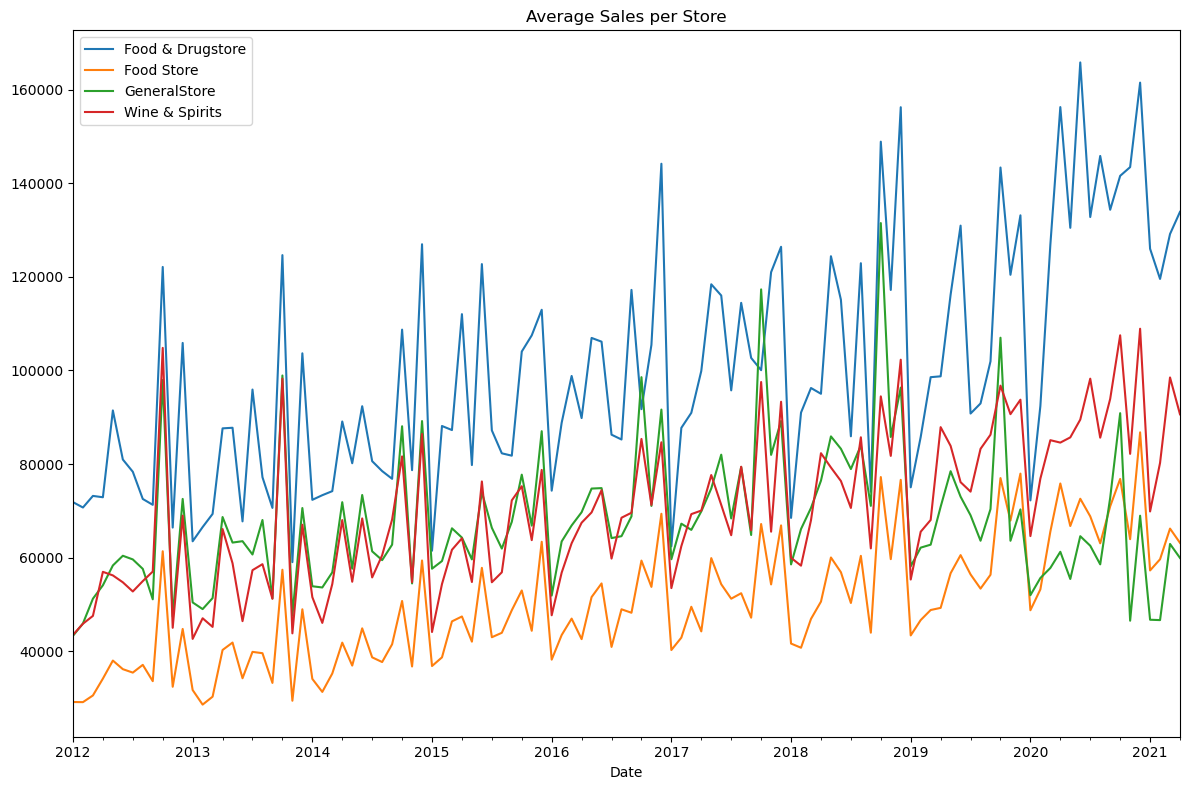

In [11]:
df = sales.groupby(['StoreType','StoreNumber',pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
df = df.reset_index().groupby(['StoreType', 'Date']).agg(
    Sale=('Sale','sum'),
    Count=('StoreNumber','count')
)

df['avg_sale_per_store'] = df.Sale/df.Count
df = df.pivot_table(index='Date', values='avg_sale_per_store', columns='StoreType')
df.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']
df

f,ax = plt.subplots(figsize = (12,8))
df.plot(ax=ax)
ax.set_title('Average Sales per Store')
f.tight_layout()

### Total number of products over time

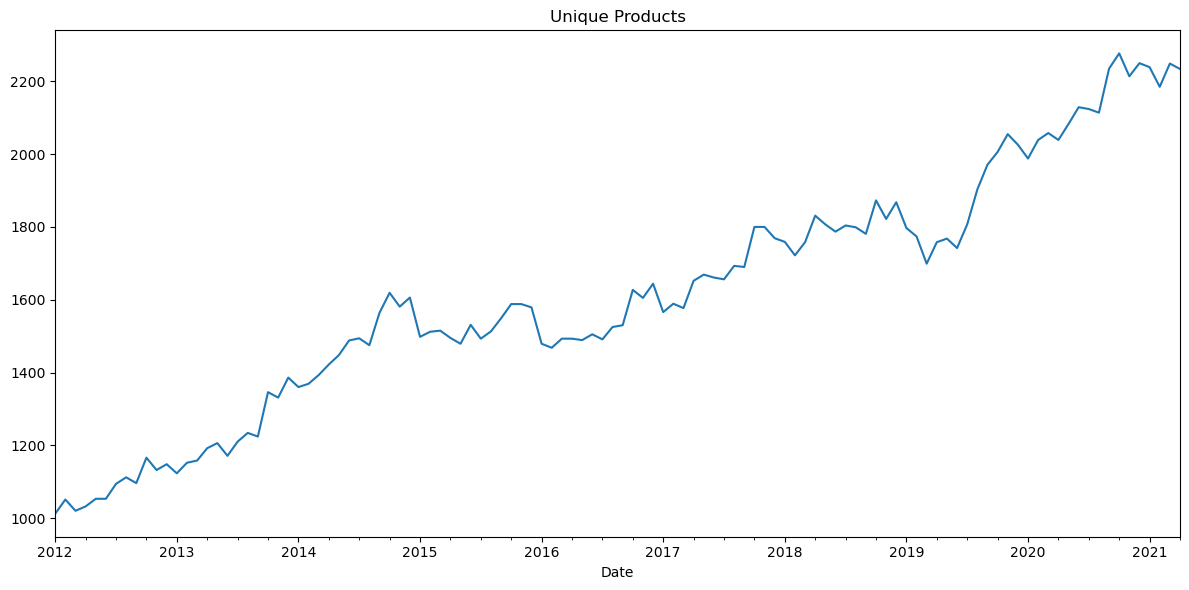

In [12]:
totalItems = sales.groupby(['ItemNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalItems = totalItems.reset_index('Date').pivot_table(index='ItemNumber', columns='Date', aggfunc=np.sum)
totalItems.columns = totalItems.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalItems.count().plot()
ax.set_title('Unique Products')
f.tight_layout()

### Total number of products by category over time
- Whiskies are increasingly popular!
- So are Iowa distilleries

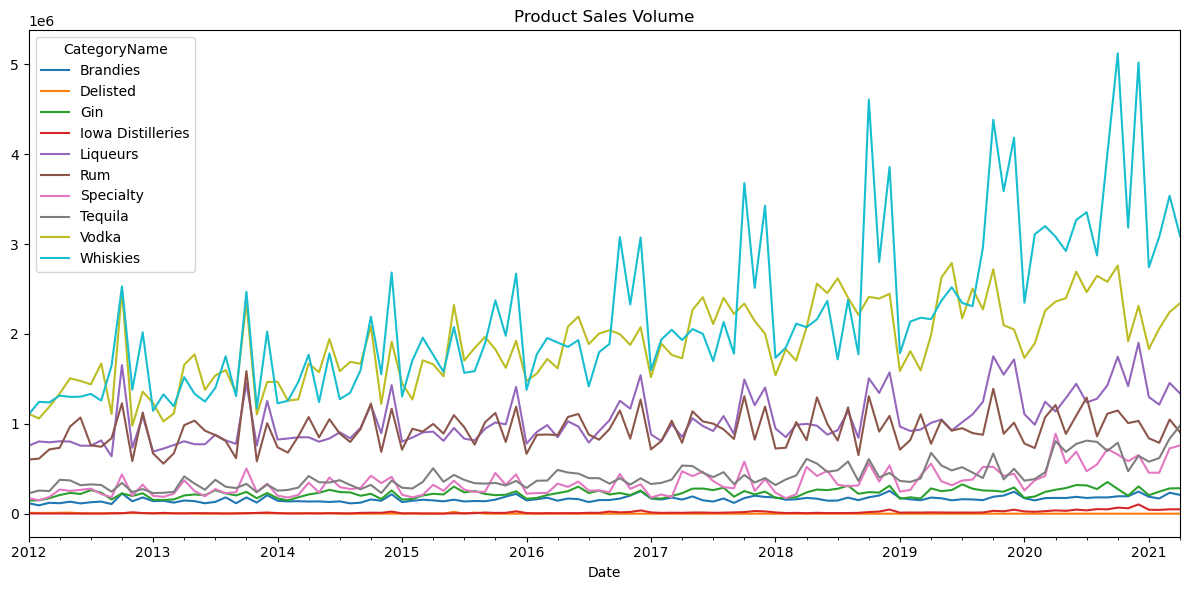

In [13]:
totalItems = sales.groupby(['CategoryName', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='CategoryName', aggfunc=np.sum)
totalItems = totalItems.fillna(0)

f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
f.tight_layout()

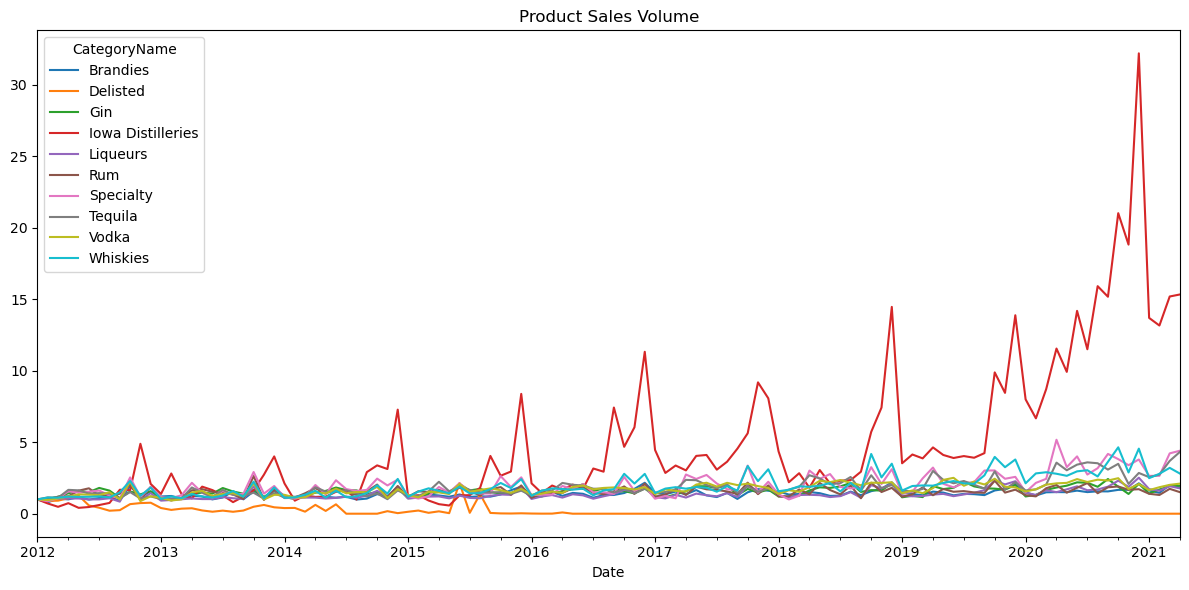

In [14]:
totalItems = sales.groupby(['CategoryName', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='CategoryName', aggfunc=np.sum)
totalItems = totalItems.fillna(0)
for col in totalItems.columns:
    totalItems[col] = totalItems[col]/totalItems[col][0]

f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
f.tight_layout()

# Store Analysis
- Check store clusters based on products and location

<AxesSubplot:ylabel='cluster'>

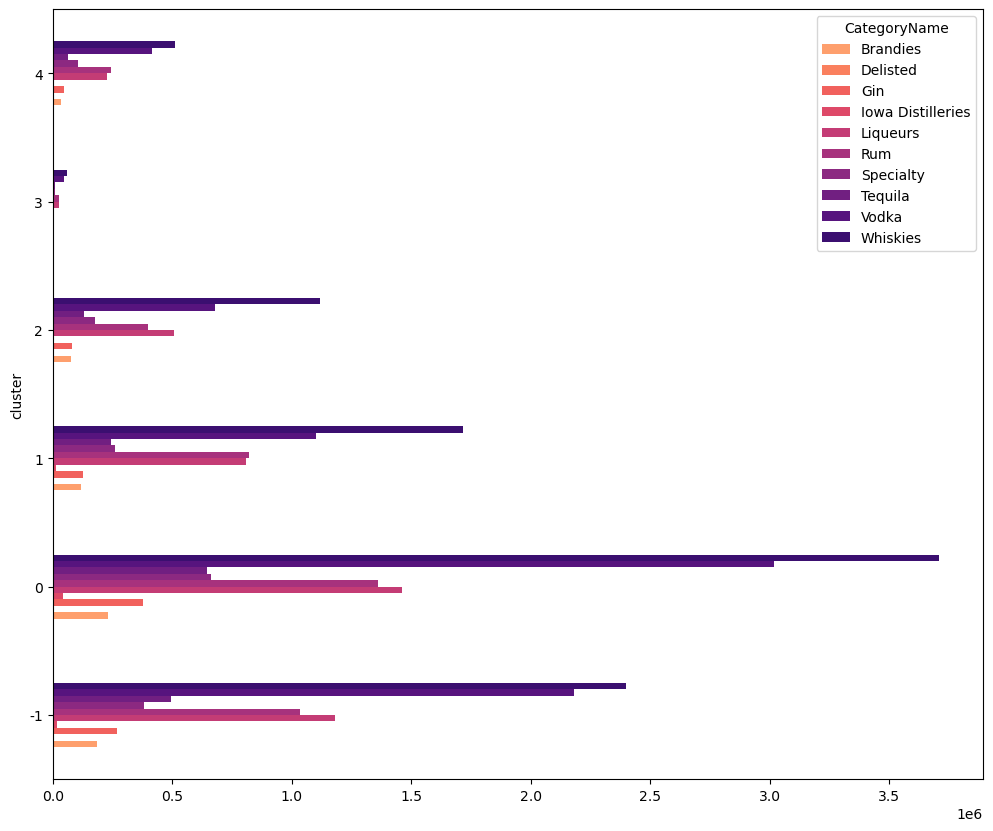

In [15]:
store_db = sales.groupby(['StoreNumber','CategoryName']).agg(Sale=('Sale','sum'),)
store_db = store_db.pivot_table(values='Sale', index='StoreNumber', columns=['CategoryName'], aggfunc=np.sum)
store_db.fillna(0, inplace=True)

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(store_db,)
store_db['cluster'] = cluster_labels
cluster_sale = store_db.groupby('cluster').mean()
cluster_sale.plot(kind='barh', cmap=new_cmap, figsize=(12,10))

### Store Location

In [16]:
store_loc = sales[['StoreNumber','Latitude','Longitude']].drop_duplicates()
store_loc = store_loc.reset_index().drop(columns='Date').set_index('StoreNumber')

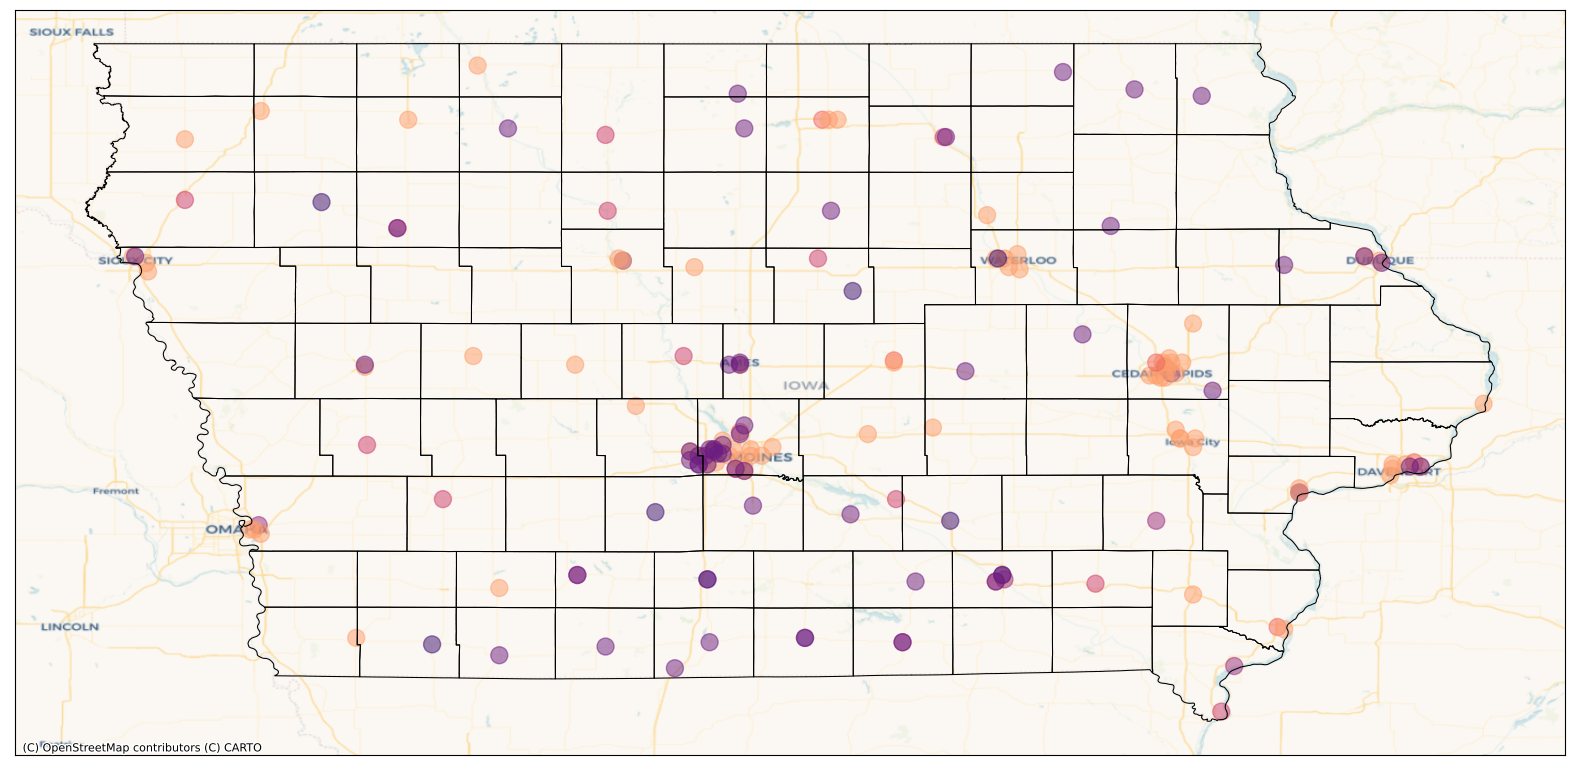

In [17]:
import geopandas
sns.color_palette("Set2")
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

import mapclassify as mc
import math
from matplotlib import rc
import contextily as ctx

counties = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
counties = counties.loc[counties.statefp=='19'] # Iowa state code
counties.index = counties.namelsad.str.replace(' County','')
counties = counties[['geoid', 'geometry']]
counties.columns = ['cty_fips', 'geometry']
counties['cty_fips'] = counties['cty_fips'].astype('int32')


store_db = store_db.merge(store_loc, on='StoreNumber')
gdf = geopandas.GeoDataFrame(
    store_db, geometry=geopandas.points_from_xy(store_db.Longitude.astype(float), store_db.Latitude.astype(float)))
gdf = gdf.set_crs(epsg=4326)


ax = gdf.plot(
    column='cluster',
    cmap=new_cmap,
    markersize=150,
    alpha=0.5,
    figsize=(20,20),
)

counties.boundary.plot(
    ax=ax,
    linewidth=0.75,
    color='black'
)

#ca_shape = ca_shape.to_crs(epsg=3857)
ctx.add_basemap(ax,
                 crs=gdf.crs.to_string(),
               source=ctx.providers.CartoDB.Voyager
              )

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

### Cluster by Location

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

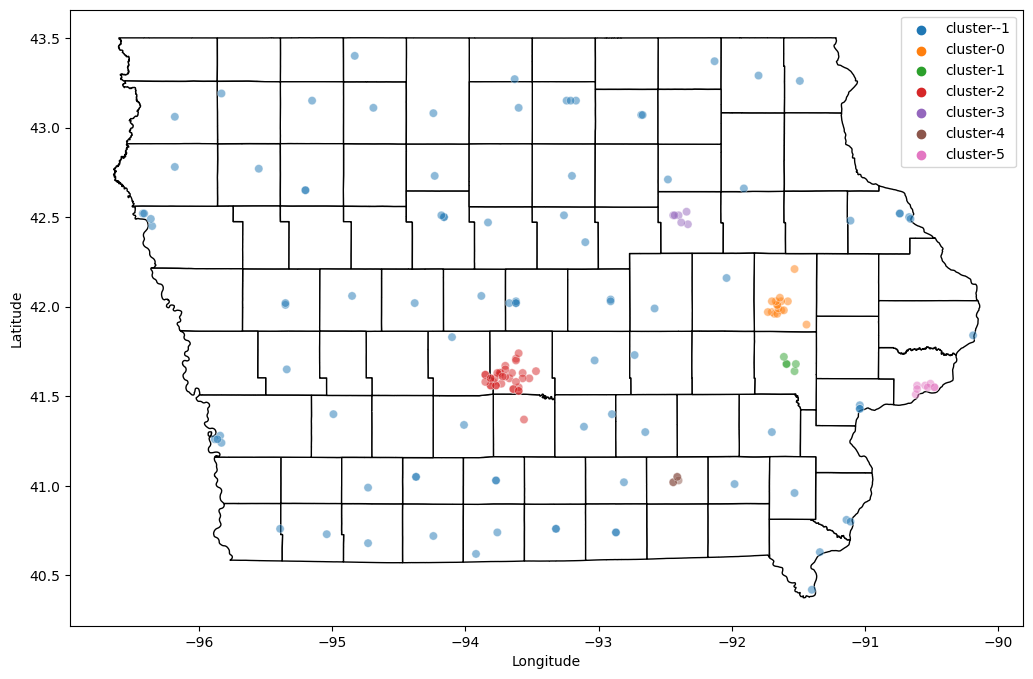

In [18]:
db = DBSCAN(eps=0.2, min_samples=5).fit(store_db[['Longitude','Latitude']])
labels = db.labels_
counties.plot(figsize=(20,8), color='white', edgecolor='black')
sns.scatterplot(store_db.loc[:,'Longitude'], store_db.loc[:,'Latitude'], alpha=0.5, hue=["cluster-{}".format(x) for x in labels])

# Store Segmentation

Goal: use unsupervised learning and the Recency, Frequency, and Monetary Value (RFM) method (https://en.wikipedia.org/wiki/RFM_(market_research) to segment stores into 
- Low Value: infrequent buyers and generate low revenues
- Mid Value: somewhat fequent buyers and generate modest revenues
- High Value: frequent buyers and generate high revenues

Then create an overall score and identify the most valuable stores to dive in deeper.

In [19]:
storeDemand = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
storeDemand = storeDemand.pivot_table(index=['StoreNumber'], columns='Date')
storeDemand.fillna(0, inplace=True)

# Recency

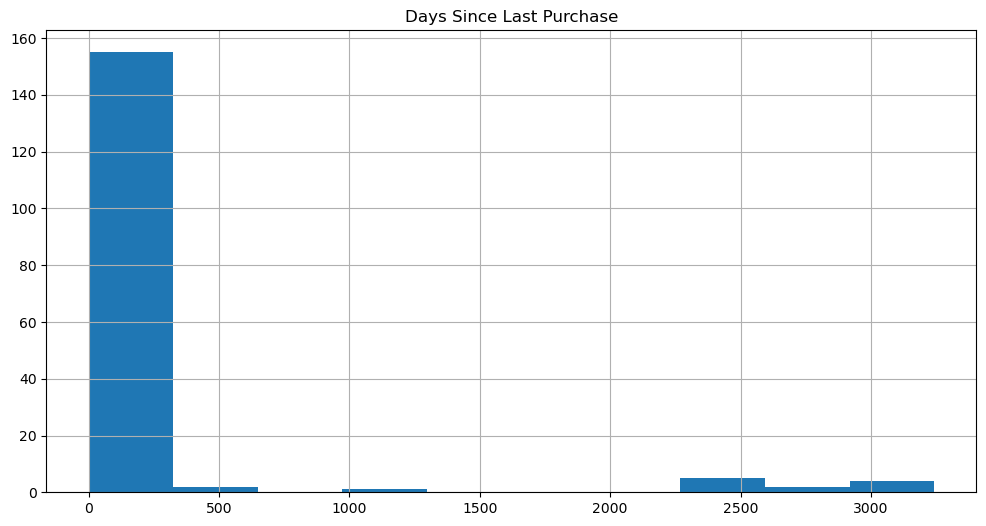

In [20]:
storeMostRecent = sales.groupby('StoreNumber').Date.max().reset_index()
storeMostRecent.columns = ['StoreNumber', 'MaxDate']
storeMostRecent['Recency'] = (storeMostRecent['MaxDate'].max() - storeMostRecent['MaxDate']).dt.days
store = pd.merge(store_loc, storeMostRecent, on='StoreNumber')
f, ax = plt.subplots(figsize = (12,6))
ax = store.Recency.hist()
ax.set_title('Days Since Last Purchase')
features = store['Recency'].to_numpy().reshape(-1,1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(storeDemand)

### Identify number of clusters for grouping stores
- Use elbow method
- Elbow occurs at 4. Choose 4 clusters.

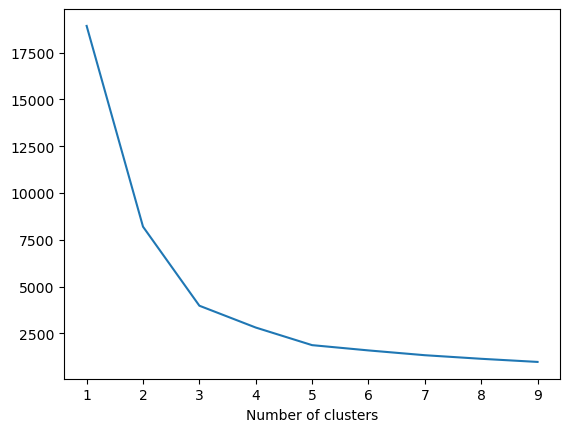

In [21]:
rng = np.random.RandomState(42)
sse={}
kmeans_features = scaled_features
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, 
                    max_iter=1000,
                    random_state=rng).fit(kmeans_features)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [22]:
kmeans = KMeans(
    init='random',
    n_clusters=4,
    n_init=10,
    max_iter=1000,
    random_state=rng
)

### Set clusters and then label stores

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

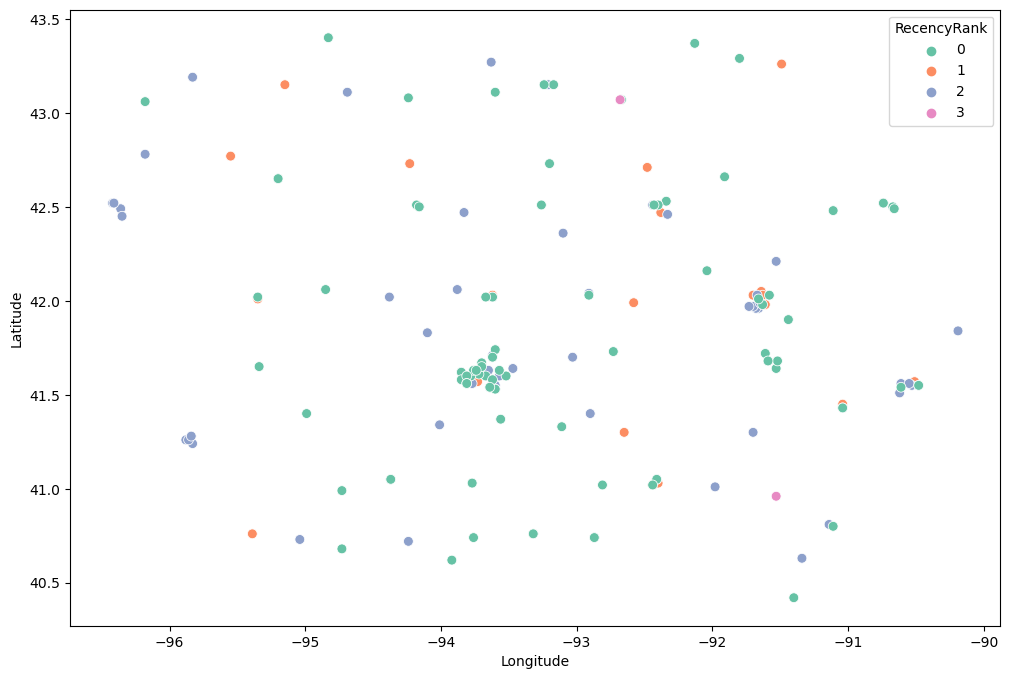

In [23]:
kmeans.fit(scaled_features)
storeCols = list(store.columns.values) + ['RecencyCluster']
RecencyCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
RecencyCluster.columns = storeCols

RecencyRanking = RecencyCluster.groupby('RecencyCluster').Recency.describe().sort_values(by='mean', ascending=False)
RecencyRanking = RecencyRanking.reset_index().reset_index()
RecencyRanking = RecencyRanking.loc[:,['index','RecencyCluster','mean']]
RecencyRanking.columns = ['RecencyRank','RecencyCluster','RecencyMean']
RecencyCluster = pd.merge(RecencyCluster, RecencyRanking, on='RecencyCluster')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=RecencyCluster,
    x='Longitude',
    y='Latitude',
    hue="RecencyRank",
    palette="Set2"
)

<AxesSubplot:xlabel='RecencyRank', ylabel='Days inactive'>

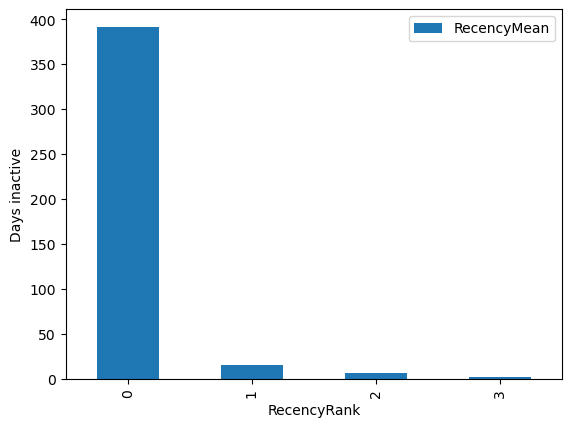

In [24]:
RecencyCluster.groupby('RecencyRank').agg(RecencyMean=('RecencyMean','mean')).plot(kind='bar', ylabel='Days inactive')

## Frequency

Text(0.5, 1.0, 'Frequency')

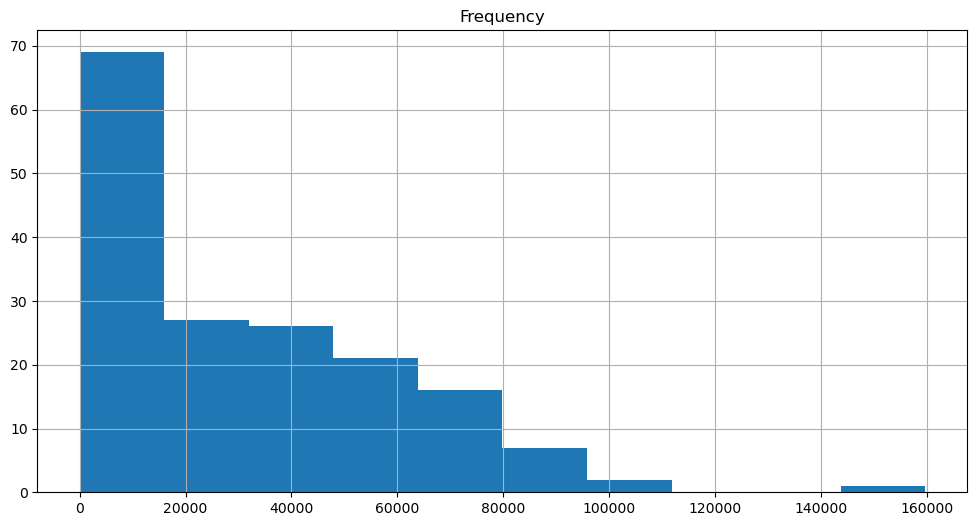

In [25]:
storeFrequency = sales.groupby('StoreNumber').Sale.count().reset_index()
storeFrequency.columns = ['StoreNumber', 'Frequency']
store = pd.merge(store_loc, storeFrequency, on ='StoreNumber')
f, ax = plt.subplots(figsize=(12,6))
ax = store.Frequency.hist()
ax.set_title('Frequency')

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

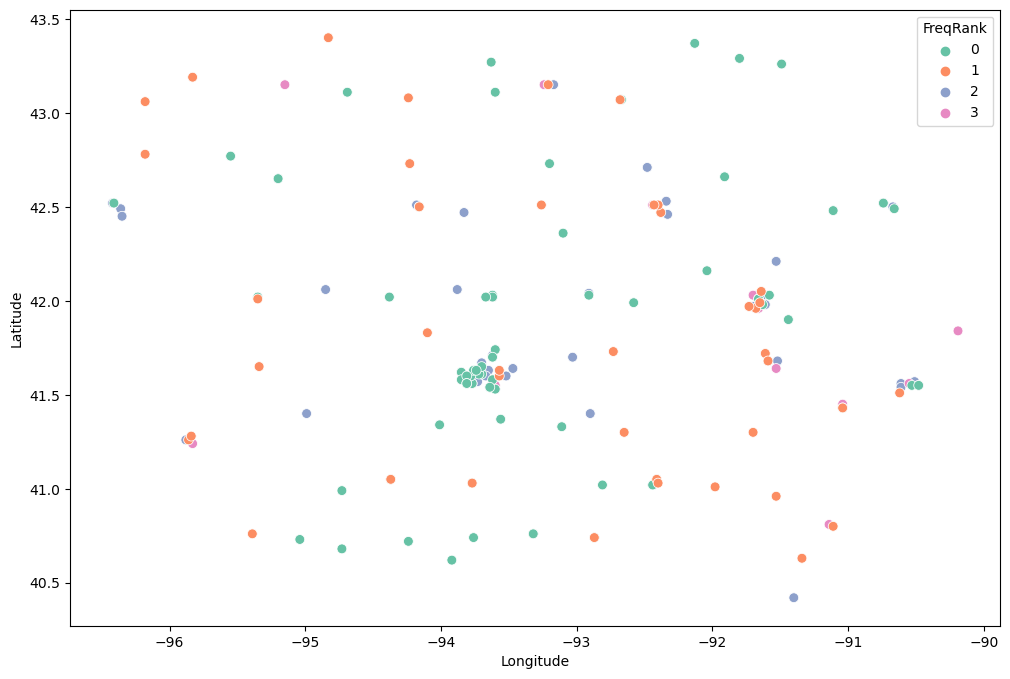

In [26]:
features = store['Frequency'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

storeCols = list(store.columns.values) + ['FreqCluster']
FreqCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
FreqCluster.columns = storeCols

FreqRanking = FreqCluster.groupby('FreqCluster').Frequency.describe().sort_values(by='mean')
FreqRanking = FreqRanking.reset_index().reset_index()
FreqRanking = FreqRanking.loc[:,['index','FreqCluster','mean']]
FreqRanking.columns = ['FreqRank','FreqCluster','FreqMean']
FreqCluster = pd.merge(FreqCluster, FreqRanking, on='FreqCluster')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=FreqCluster,
    x='Longitude',
    y='Latitude',
    hue="FreqRank",
    palette="Set2"
)

<AxesSubplot:xlabel='FreqRank', ylabel='Number of transactions'>

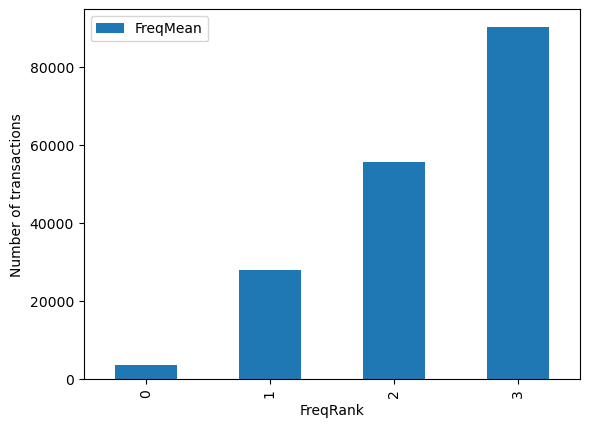

In [27]:
FreqCluster.groupby('FreqRank').agg(FreqMean=('FreqMean','mean')).plot(kind='bar', ylabel='Number of transactions')

## Sale Volume

Text(0.5, 1.0, 'Value')

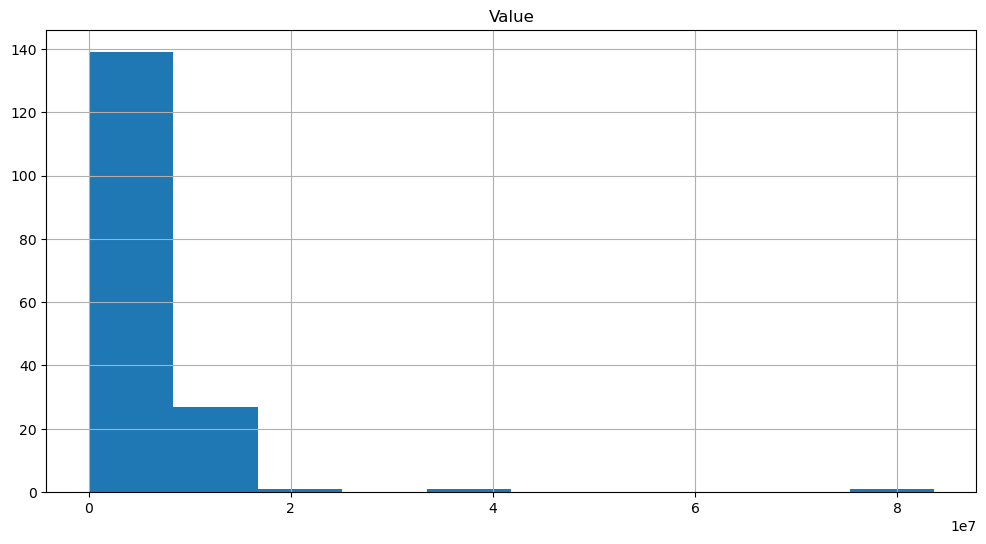

In [28]:
storeSale = sales.groupby('StoreNumber').Sale.sum().reset_index()
storeSale.columns = ['StoreNumber', 'Value']
store = pd.merge(store_loc, storeSale, on ='StoreNumber')
f, ax = plt.subplots(figsize=(12,6))
ax = store.Value.hist()
ax.set_title('Value')

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

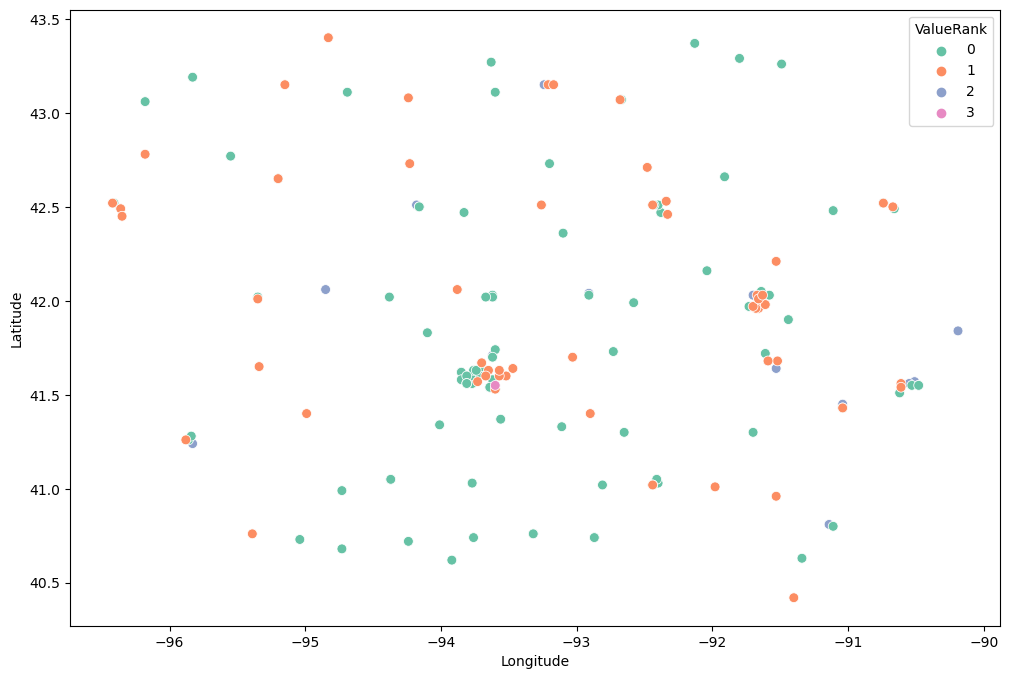

In [29]:
features = store['Value'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

storeCols = list(store.columns.values) + ['ValueCluster']
ValueCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
ValueCluster.columns = storeCols

ValueRanking = ValueCluster.groupby('ValueCluster').Value.describe().sort_values(by='mean')
ValueRanking = ValueRanking.reset_index().reset_index()
ValueRanking = ValueRanking.loc[:,['index','ValueCluster','mean']]
ValueRanking.columns = ['ValueRank','ValueCluster','ValueMean']

ValueCluster = pd.merge(ValueCluster,ValueRanking, on = 'ValueCluster')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=ValueCluster,
    x='Longitude',
    y='Latitude',
    hue="ValueRank",
    palette="Set2"
)

<AxesSubplot:xlabel='ValueRank', ylabel='Total Sale Volume'>

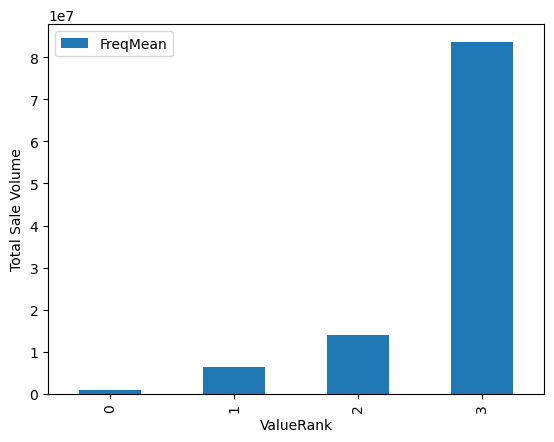

In [30]:
ValueCluster.groupby('ValueRank').agg(FreqMean=('ValueMean','mean')).plot(kind='bar', ylabel='Total Sale Volume')

## Overall Score

In [31]:
final_score = pd.merge(store, RecencyCluster[['StoreNumber','RecencyRank']], on='StoreNumber')
final_score = pd.merge(final_score, FreqCluster[['StoreNumber','FreqRank']], on='StoreNumber')
final_score = pd.merge(final_score, ValueCluster[['StoreNumber','ValueRank']], on='StoreNumber')

final_score['OverallScore'] =  final_score['RecencyRank'] + final_score['FreqRank'] + final_score['ValueRank']
final_score['CustomerSegment'] = '1 Low-Value'
final_score.loc[final_score['OverallScore']>2, 'CustomerSegment'] = '2 Mid-Value'
final_score.loc[final_score['OverallScore']>4, 'CustomerSegment'] = '3 High-Value'

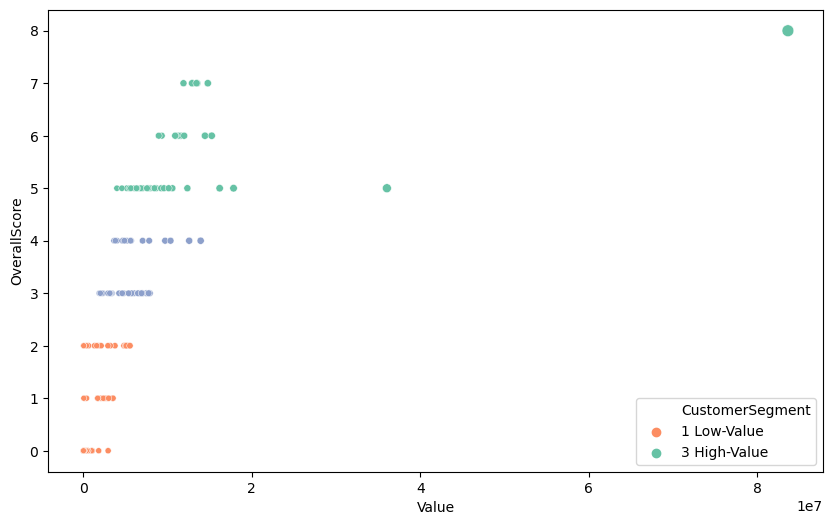

In [32]:
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=final_score,
    y='OverallScore',
    x='Value',
    hue='CustomerSegment',
    size=final_score['Value'],
    palette='Set2',
    ax=ax
)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc=4)

Which stores are the high value ones?
- StoreNumber: 2633

In [33]:
final_score[(final_score.Value>3*10e6) & (final_score.OverallScore>7)]

StoreNumber  Latitude  Longitude         Value  RecencyRank  FreqRank  \
65         2633     41.55      -93.6  8.364864e+07            2         3   

    ValueRank  OverallScore CustomerSegment  
65          3             8    3 High-Value

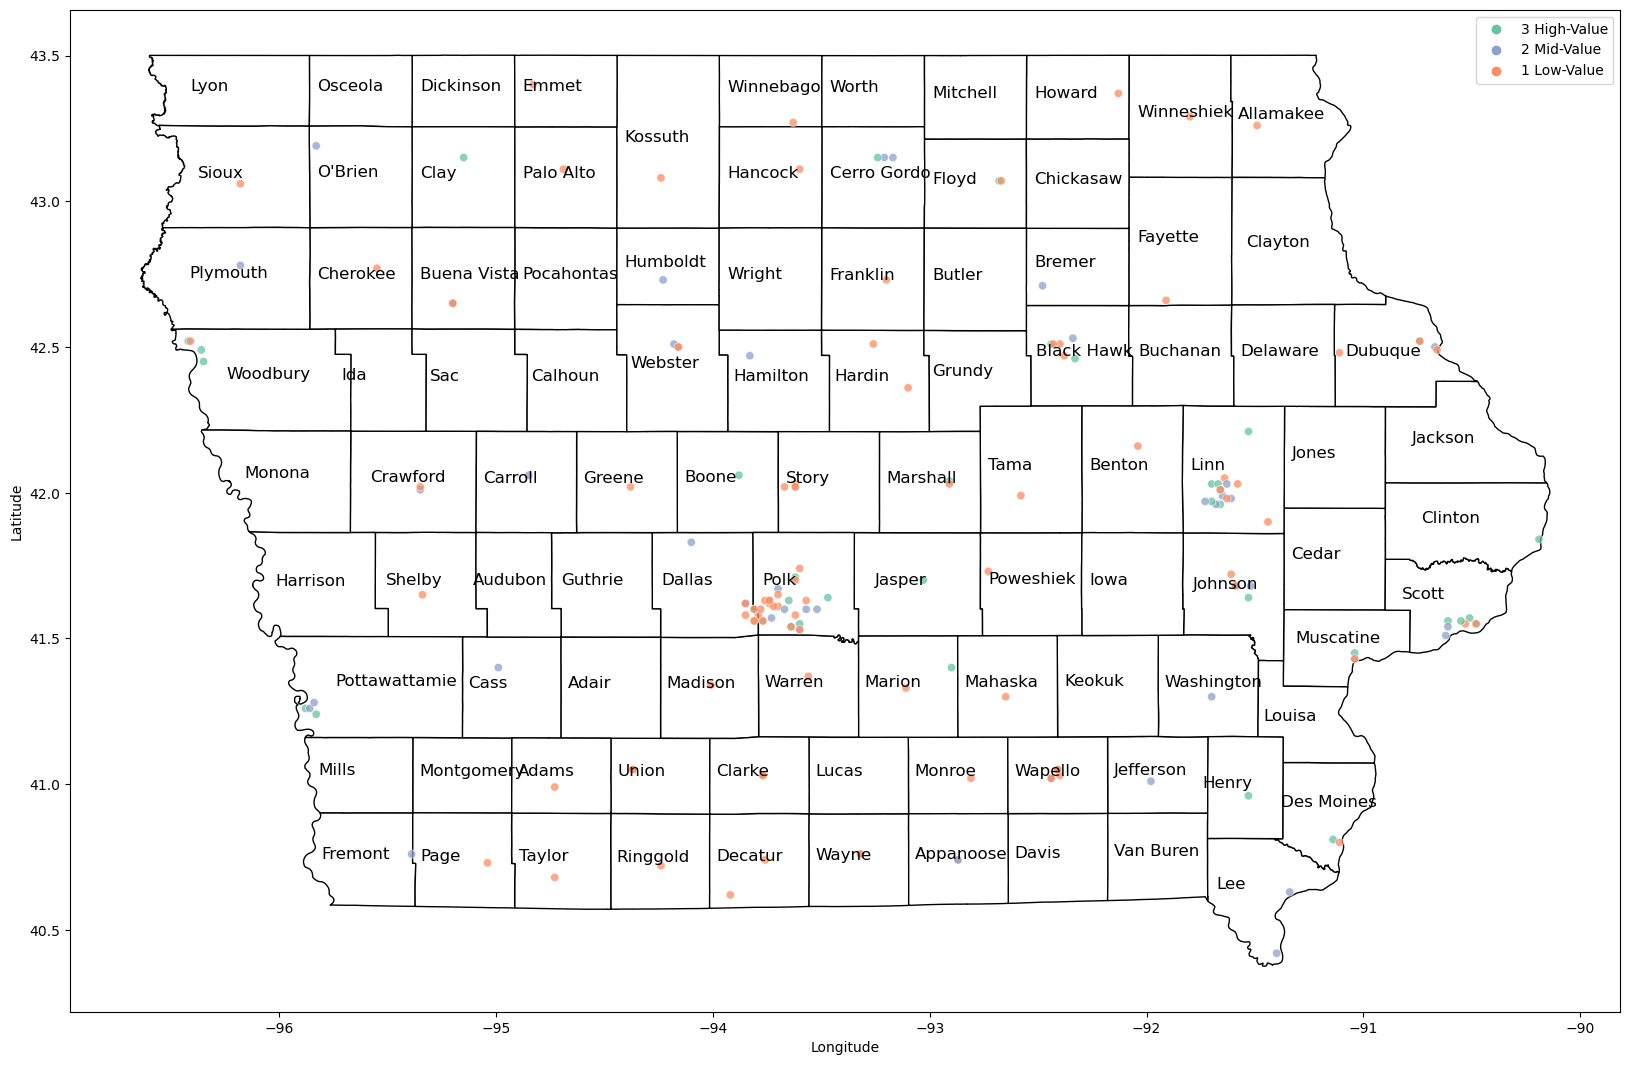

In [34]:
f, ax = plt.subplots(figsize=(20, 15))
counties.plot(color='white', edgecolor='black', ax=ax)
sns.scatterplot(
    data=final_score,
    x='Longitude',
    y='Latitude',
    hue='CustomerSegment',
    palette='Set2',
    alpha=0.75,
    ax=ax,
)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc=1)

counties = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
counties = counties[counties.statefp=='19'] # Iowa state code
counties.namelsad = counties.namelsad.str.replace(' County','')
counties = counties[['namelsad', 'geoid', 'geometry']]
counties.columns = ['name', 'cty_fips', 'geometry']
for name in counties.name:
    x = counties[counties.name==name].geometry.centroid.x-0.2
    y = counties[counties.name==name].geometry.centroid.y
    plt.annotate(name, (x, y), fontsize=12)

In [35]:
xlsx_path = 'https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres-19.xlsx'
iowa_pop = pd.read_excel(xlsx_path, skiprows=3,skipfooter=5)
iowa_pop = iowa_pop.loc[1:]
iowa_pop.columns = ['County' if i == 'Unnamed: 0' else i for i in iowa_pop.columns]
iowa_pop['County'] = [i.replace('.', '') for i in iowa_pop.County]

In [36]:
unique_stores = sales[sales.index.year==2019]
unique_stores = unique_stores.reset_index(drop=True)[['StoreNumber','County']].drop_duplicates()
unique_stores = unique_stores.reset_index(drop=True)
unique_stores.loc[unique_stores['County']=='Buena Vist', 'County'] = 'Buena Vista'
unique_stores.loc[unique_stores['County']=='Pottawatta', 'County'] = 'Pottawattamie'
unique_stores.loc[unique_stores['County']=='Obrien', 'County'] = "O'Brien"
unique_stores.loc[unique_stores['County']=='Cerro Gord', 'County'] = "Cerro Gordo"
print(unique_stores.shape)
unique_stores['County'] = unique_stores['County'] + " County, Iowa"
unique_stores = unique_stores.merge(iowa_pop, left_on='County', right_on='County')
print(unique_stores.shape)
unique_stores.County = unique_stores.County.str.replace('County, Iowa','').str.strip()
unique_stores.index = unique_stores.County
unique_stores.drop(columns='County',inplace=True)
unique_stores.columns = [str(i) for i in unique_stores.columns]
unique_stores = unique_stores.groupby('County').agg(
    Freq=('2019','count'), 
    Pop2019=('2019', 'mean')
)
unique_stores['store_per_1000pop'] = unique_stores['Freq']/unique_stores['Pop2019'] * 1000

(136, 2)
(136, 14)


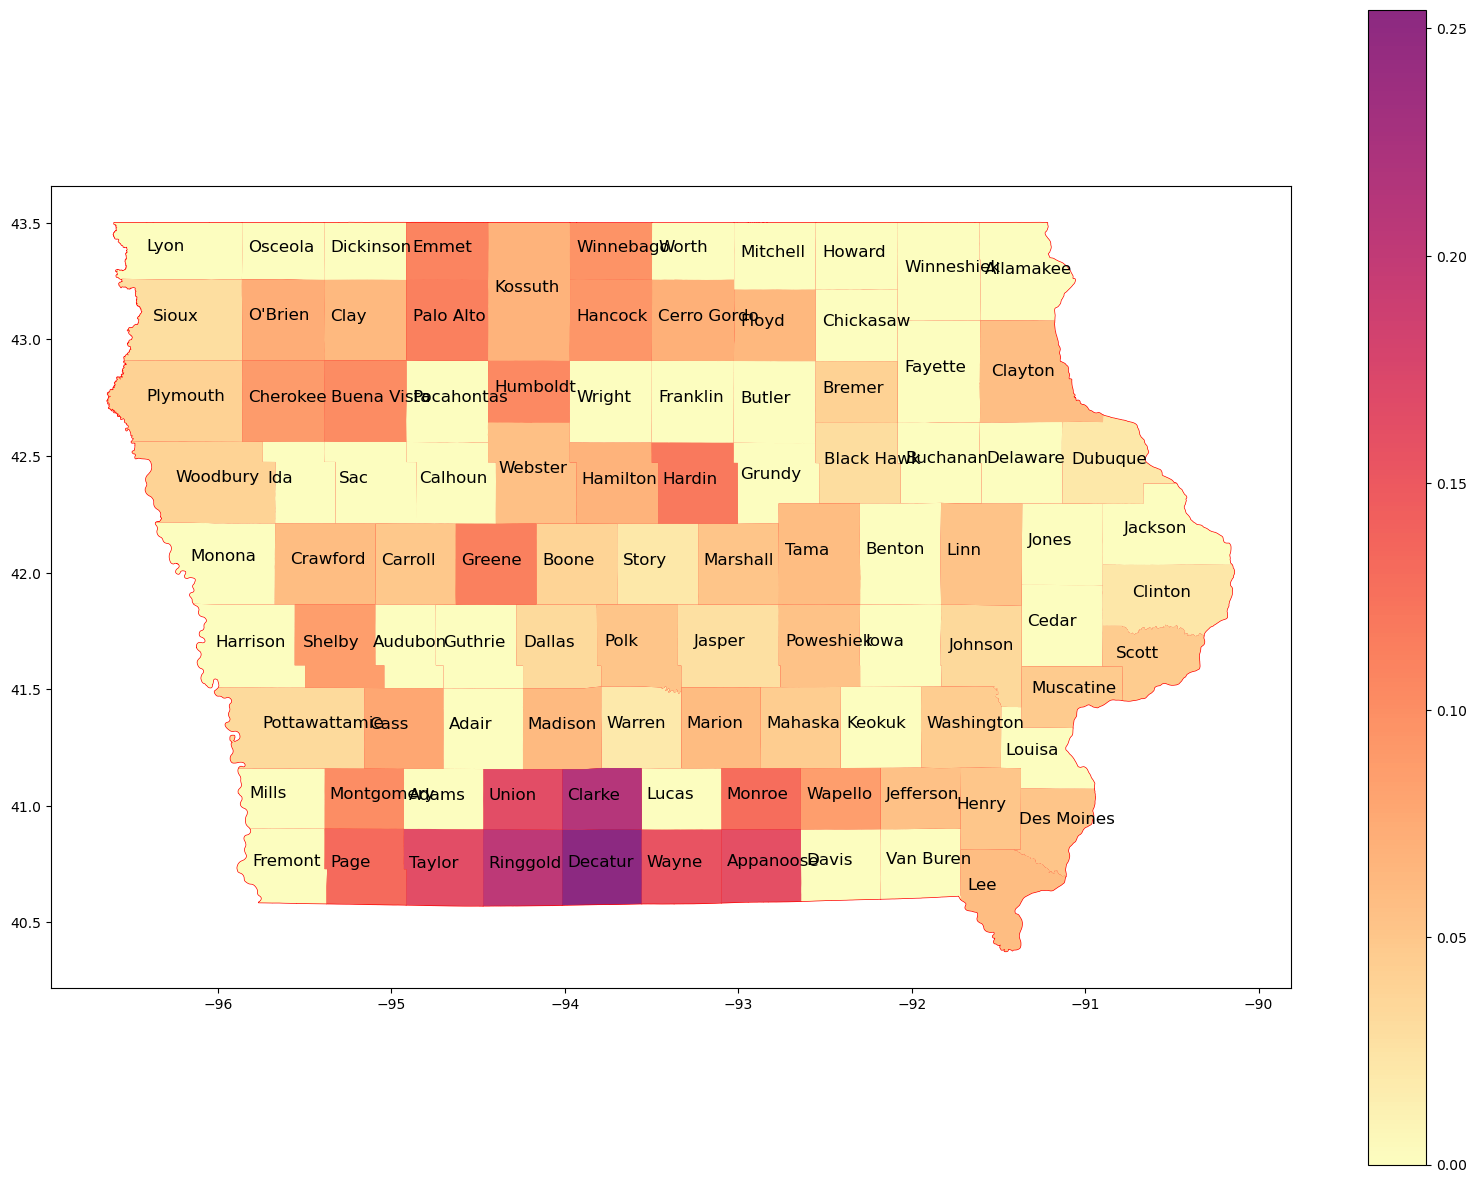

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0, 0.6)

# Stores per 1000pop (County level)
store_per_1000pop_counties = counties.reset_index().merge(
    unique_stores.reset_index(), 
    right_on='County', 
    left_on='name',
    how='left',
)
store_per_1000pop_counties.fillna(0, inplace=True)
fig, ax = plt.subplots(1, 1,  figsize=(20,15))
store_per_1000pop_counties.plot(color='white', edgecolor='red', ax=ax)
store_per_1000pop_counties.plot(column='store_per_1000pop', cmap=new_cmap, ax=ax, legend=True)

loc = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
loc = loc[loc.statefp=='19'] # Iowa state code
loc.namelsad = loc.namelsad.str.replace(' County','')
loc = loc[['namelsad', 'geoid', 'geometry']]
loc.columns = ['name', 'cty_fips', 'geometry']
for name in loc.name:
    x = loc[loc.name==name].geometry.centroid.x-0.2
    y = loc[loc.name==name].geometry.centroid.y
    plt.annotate(name, (x, y), fontsize=12)

# Market Basket Analysis Using Highest Value Store
- Identify top 100 items with highest sales
- Then perform MBA

In [38]:
conn = sqlite3.connect('IowaLiquor.db')
product_name = pd.read_sql_query(
    "SELECT ItemNumber, ItemDescription from Item", conn
)
product_name = product_name.astype(str)

In [39]:
item = sales.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(product_name, on='ItemNumber')

In [40]:
store = sales[sales.StoreNumber==2633]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index()['ItemNumber'], on='ItemNumber')
store = store.groupby(['ItemDescription',pd.Grouper(key = 'Date', freq='W')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns='ItemDescription', aggfunc=np.sum)
store.fillna(0, inplace=True)
store

ItemDescription  10 Cane Rum DISCO  1792 12YR Old Bourbon  \
Date                                                        
2012-01-08                     0.0                    0.0   
2012-01-15                     0.0                    0.0   
2012-01-22                     0.0                    0.0   
2012-01-29                     0.0                    0.0   
2012-02-05                     0.0                    0.0   
...                            ...                    ...   
2021-04-04                     0.0                    0.0   
2021-04-11                     0.0                    0.0   
2021-04-18                     0.0                    0.0   
2021-04-25                     0.0                    0.0   
2021-05-02                     0.0                    0.0   

ItemDescription  1792 Bottled in Bond Bourbon  1792 Full Proof  \
Date                                                             
2012-01-08                                0.0              0.0   
2012-01-15                                0.0              0.0   
2012-01-22                                0.0              0.0   
2012-01-29                                0.0              0.0   
2012-02-05                                0.0              0.0   
...                                       ...              ...   
2021-04-04                                0.0              0.0   
2021-04-11                                0.0             36.0   
2021-04-18                                0.0             36.0   
2021-04-25                                0.0              0.0   
2021-05-02                                0.0              0.0   

ItemDescription  1792 Single Barrel Bourbon  1792 Sweet Wheat Bourbon  \
Date                                                                    
2012-01-08                              0.0                       0.0   
2012-01-15                              0.0                       0.0   
2012-01-22                              0.0                       0.0   
2012-01-29                              0.0                       0.0   
2012-02-05                              0.0                       0.0   
...                                     ...                       ...   
2021-04-04                              0.0                       0.0   
2021-04-11                              0.0                       0.0   
2021-04-18                              0.0                       0.0   
2021-04-25                              0.0                       0.0   
2021-05-02                              0.0                       0.0   

ItemDescription  1800 Anejo  1800 Coconut  1800 Cristalino  1800 Reposado  \
Date                                                                        
2012-01-08             0.00           0.0             0.00         521.76   
2012-01-15             0.00           0.0             0.00         521.76   
2012-01-22             0.00           0.0             0.00         521.76   
2012-01-29             0.00           0.0             0.00         521.76   
2012-02-05             0.00           0.0             0.00         521.76   
...                     ...           ...              ...            ...   
2021-04-04             0.00           0.0             0.00       10822.50   
2021-04-11             0.00           0.0             0.00           0.00   
2021-04-18             0.00           0.0             0.00           0.00   
2021-04-25             0.00           0.0           267.84           0.00   
2021-05-02            67.24           0.0             0.00           0.00   

ItemDescription  ...  Writers Tears Copper Pot  \
Date             ...                             
2012-01-08       ...                      0.00   
2012-01-15       ...                      0.00   
2012-01-22       ...                      0.00   
2012-01-29       ...                      0.00   
2012-02-05       ...                      0.00   
...              ...                       ..

In [41]:
for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)
store

ItemDescription  10 Cane Rum DISCO  1792 12YR Old Bourbon  \
Date                                                        
2012-01-08                       0                      0   
2012-01-15                       0                      0   
2012-01-22                       0                      0   
2012-01-29                       0                      0   
2012-02-05                       0                      0   
...                            ...                    ...   
2021-04-04                       0                      0   
2021-04-11                       0                      0   
2021-04-18                       0                      0   
2021-04-25                       0                      0   
2021-05-02                       0                      0   

ItemDescription  1792 Bottled in Bond Bourbon  1792 Full Proof  \
Date                                                             
2012-01-08                                  0                0   
2012-01-15                                  0                0   
2012-01-22                                  0                0   
2012-01-29                                  0                0   
2012-02-05                                  0                0   
...                                       ...              ...   
2021-04-04                                  0                0   
2021-04-11                                  0                1   
2021-04-18                                  0                1   
2021-04-25                                  0                0   
2021-05-02                                  0                0   

ItemDescription  1792 Single Barrel Bourbon  1792 Sweet Wheat Bourbon  \
Date                                                                    
2012-01-08                                0                         0   
2012-01-15                                0                         0   
2012-01-22                                0                         0   
2012-01-29                                0                         0   
2012-02-05                                0                         0   
...                                     ...                       ...   
2021-04-04                                0                         0   
2021-04-11                                0                         0   
2021-04-18                                0                         0   
2021-04-25                                0                         0   
2021-05-02                                0                         0   

ItemDescription  1800 Anejo  1800 Coconut  1800 Cristalino  1800 Reposado  \
Date                                                                        
2012-01-08                0             0                0              1   
2012-01-15                0             0                0              1   
2012-01-22                0             0                0              1   
2012-01-29                0             0                0              1   
2012-02-05                0             0                0              1   
...                     ...           ...              ...            ...   
2021-04-04                0             0                0              1   
2021-04-11                0             0                0              0   
2021-04-18                0             0                0              0   
2021-04-25                0             0                1              0   
2021-05-02                1             0                0              0   

ItemDescription  ...  Writers Tears Copper Pot  \
Date             ...                             
2012-01-08       ...                         0   
2012-01-15       ...                         0   
2012-01-22       ...                         0   
2012-01-29       ...                         0   
2012-02-05       ...                         0   
...              ...                       ..

In [42]:
freq_itemsets = apriori(store, min_support=0.5, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.6) & (rules['confidence']>0.8)]

antecedents                 consequents  antecedent support  \
0          (1800 Reposado)            (Absolut Citron)            0.665298   
2          (1800 Reposado)           (Absolut Mandrin)            0.665298   
6          (1800 Reposado)     (Admiral Nelson Spiced)            0.665298   
8          (1800 Reposado)      (Arrow Peach Schnapps)            0.665298   
10         (1800 Reposado)  (Arrow Raspberry Schnapps)            0.665298   
...                    ...                         ...                 ...   
15701           (UV Grape)         (UV Blue Raspberry)            0.969199   
15702      (UV Red Cherry)         (UV Blue Raspberry)            0.946612   
15703  (UV Blue Raspberry)             (UV Red Cherry)            0.940452   
15704      (UV Red Cherry)                  (UV Grape)            0.946612   
15705           (UV Grape)             (UV Red Cherry)            0.969199   

       consequent support   support  confidence      lift  leverage  \
0                0.911704  0.611910    0.919753  1.008828  0.005355   
2                0.878850  0.595483    0.895062  1.018446  0.010786   
6                0.804928  0.554415    0.833333  1.035289  0.018898   
8                0.882957  0.607803    0.913580  1.034683  0.020374   
10               0.921971  0.634497    0.953704  1.034418  0.021112   
...                   ...       ...         ...       ...       ...   
15701            0.940452  0.932238    0.961864  1.022768  0.020753   
15702            0.940452  0.921971    0.973970  1.035640  0.031728   
15703            0.946612  0.921971    0.980349  1.035640  0.031728   
15704            0.969199  0.942505    0.995662  1.027303  0.025050   
15705            0.946612  0.942505    0.972458  1.027303  0.025050   

       conviction  
0        1.100300  
2        1.154487  
6        1.170431  
8        1.354356  
10       1.685421  
...           ...  
15701    1.561488  
15702    2.287645  
15703    2.716861  
15704    7.099589  
15705    1.938398  

[10498 rows x 9 columns]

In [43]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[rules.conviction!=np.inf][['antecedents', 'consequents','confidence']].head(20)

antecedents      consequents  confidence
11395                        (Paramount Amaretto)  (Hawkeye Vodka)    0.997890
11450                             (Tanqueray Gin)  (Hawkeye Vodka)    0.997890
11470                                  (UV Grape)  (Hawkeye Vodka)    0.997881
8783                 (Dekuyper Sour Apple Pucker)  (Hawkeye Vodka)    0.997877
5741                        (Castillo Silver Rum)  (Hawkeye Vodka)    0.997877
11411                        (Phillips White Rum)  (Hawkeye Vodka)    0.997872
9301                 (Dekuyper Watermelon Pucker)  (Hawkeye Vodka)    0.997872
2321                              (Bacardi Limon)  (Hawkeye Vodka)    0.997868
2057                       (Bacardi Dragon Berry)  (Hawkeye Vodka)    0.997863
7831                       (Dekuyper Buttershots)  (Hawkeye Vodka)    0.997845
8434                (Dekuyper Luscious Peachtree)  (Hawkeye Vodka)    0.997840
4419                        (Bombay Sapphire Gin)  (Hawkeye Vodka)    0.997840
11153                   (Hawkeye Blended Whiskey)  (Hawkeye Vodka)    0.997840
11407                              (Phillips Gin)  (Hawkeye Vodka)    0.997835
11472                             (UV Red Cherry)  (Hawkeye Vodka)    0.997831
3123                                 (Barton Gin)  (Hawkeye Vodka)    0.997826
11468                         (UV Blue Raspberry)  (Hawkeye Vodka)    0.997817
11417  (Rumple Minze Peppermint Schnapps Liqueur)  (Hawkeye Vodka)    0.997812
1660                   (Arrow Raspberry Schnapps)  (Hawkeye Vodka)    0.997773
11362                                 (Ketel One)  (Hawkeye Vodka)    0.997768

# Introducing Time Series

- Demand forcasting
- Forecast recovery

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (6,8)})

# Monthly sales data
sales = sales[sales.index.year>=2014]
allstores = sales.groupby(pd.Grouper(key = 'Date', freq='M')).agg(sales=('Sale','sum'))
highval = sales[sales.StoreNumber==2633].groupby(pd.Grouper(key = 'Date', freq='M')).agg(sales=('Sale','sum'))

### Check seasonality - additive decomposition seems to work better.
- Residual looks random and centered around zero for additive decomposition model.

Text(0.6, 1, 'All Hy-Vee Stores')

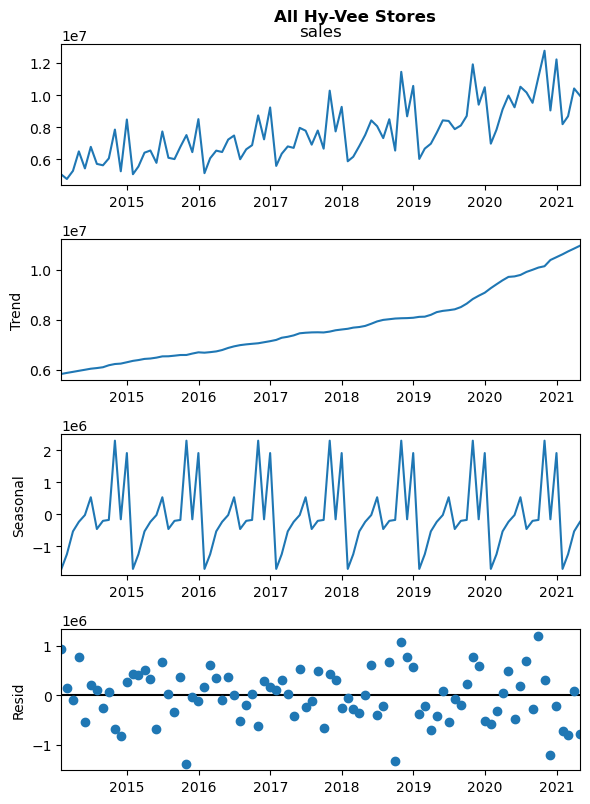

In [45]:
allstore_decomp = seasonal_decompose(allstores['sales'], model='additive', extrapolate_trend='freq')
allstore_decomp.plot().suptitle('All Hy-Vee Stores', fontsize=12,y=1,x=0.6,fontweight='bold')

Text(0.6, 1, 'High-value store')

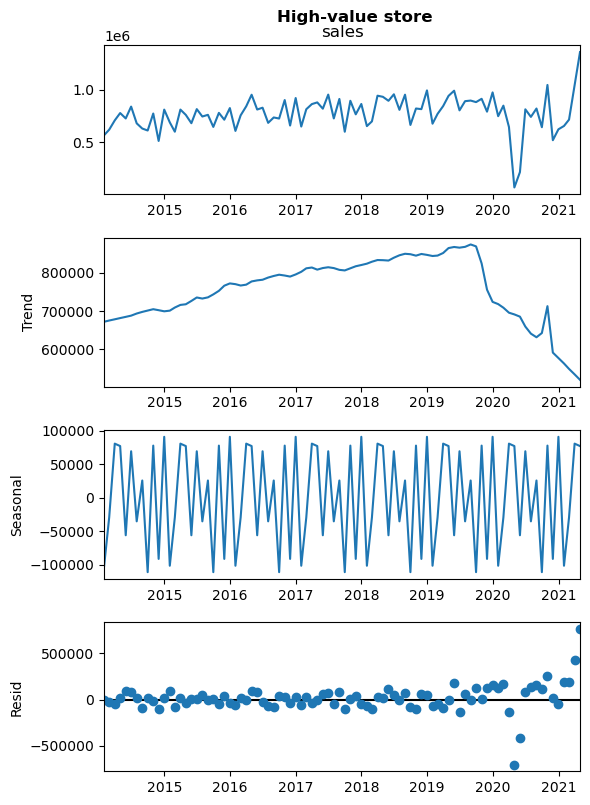

In [46]:
highval_decomp = seasonal_decompose(highval['sales'], model='additive', extrapolate_trend='freq')
highval_decomp.plot().suptitle('High-value store', fontsize=12,y=1,x=0.6,fontweight='bold')

### Check stationarity
- Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. In other words, statistical properties of the series like mean, variance and autocorrelation are constant over time.


### Tests
- Unit root test (Augmented Dickey Fuller test): null hypothesis is the time series possesses a unit root and is non-stationary. When P-Value in ADH test is less than the significance level chosen, reject the null hypothesis and the series is assumed to be stationary.
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary): null hypothesis is that the trend is stationary. When the p-value in the kPSS test is less than the significance level chosen, reject the null and assume the series is non-stationary (opposite of the interpretatin of ADF).

In [47]:
# ADF Test
result = adfuller(allstores.sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1]<0.05:
    print(f'Since p-value {result[1]} is less than 0.05 critical value, ADF null is rejected and series is stationary.')
else:
    print('Null hypothesis of ADF is not rejected. Series is not stationary.')

# KPSS Test
result = kpss(allstores.sales.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1]<0.05:
    print(f'Since p-value {result[1]} is less than 0.05 critical value, KPSS null is rejected and series is NOT stationary.')
else:
    print('Null hypothesis of KPSS is not rejected. Series is stationary.')    

ADF Statistic: 3.1131987405217627
p-value: 1.0
Critial Values:
   1%, -3.5194805351545413
Critial Values:
   5%, -2.9003945086747343
Critial Values:
   10%, -2.5874984279778395
Null hypothesis of ADF is not rejected. Series is not stationary.

KPSS Statistic: 0.759582
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
Since p-value 0.01 is less than 0.05 critical value, KPSS null is rejected and series is NOT stationary.


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Removing trends and seasonality

Text(0.5, 1.0, 'De-trended Drug Sales')

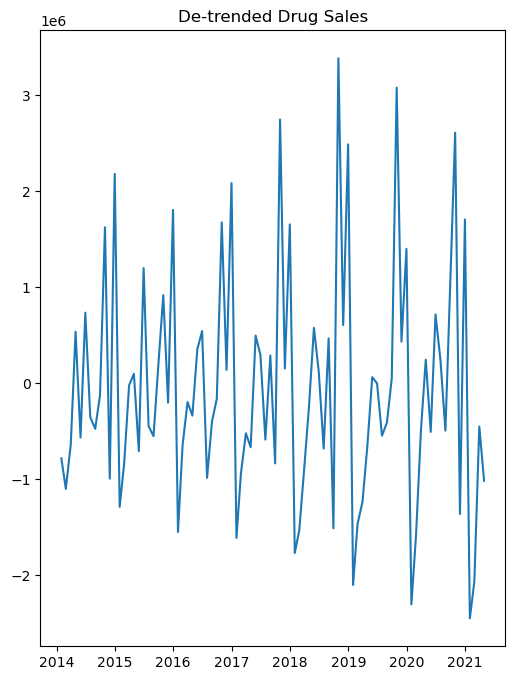

In [48]:
detrended = allstores.sales.values - allstore_decomp.trend
plt.plot(detrended)
plt.title('De-trended Drug Sales', fontsize=12)

Text(0.5, 1.0, 'De-seasonal Drug Sales')

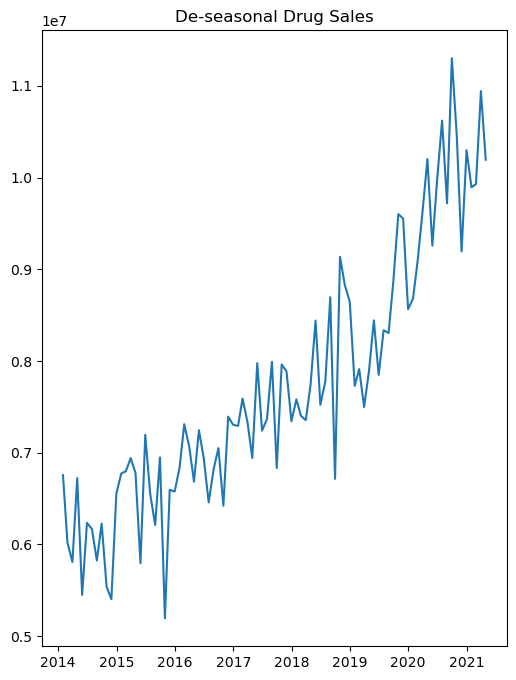

In [49]:
deseasonal = allstores.sales.values - allstore_decomp.seasonal
plt.plot(deseasonal)
plt.title('De-seasonal Drug Sales', fontsize=12)

### Autocorrelation decraeses and plateaus around 300 lag before increasing again

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

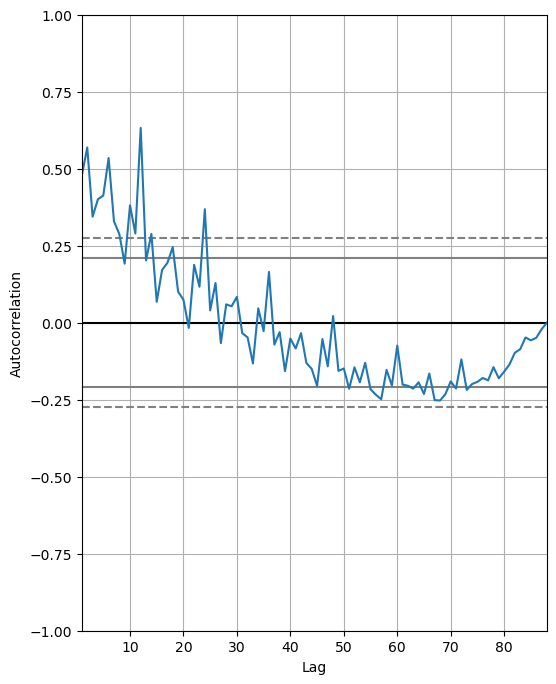

In [50]:
autocorrelation_plot(allstores.sales.tolist())

### Order of differencing (d)
- Series appears stationary after first-differencing
- Set d=1

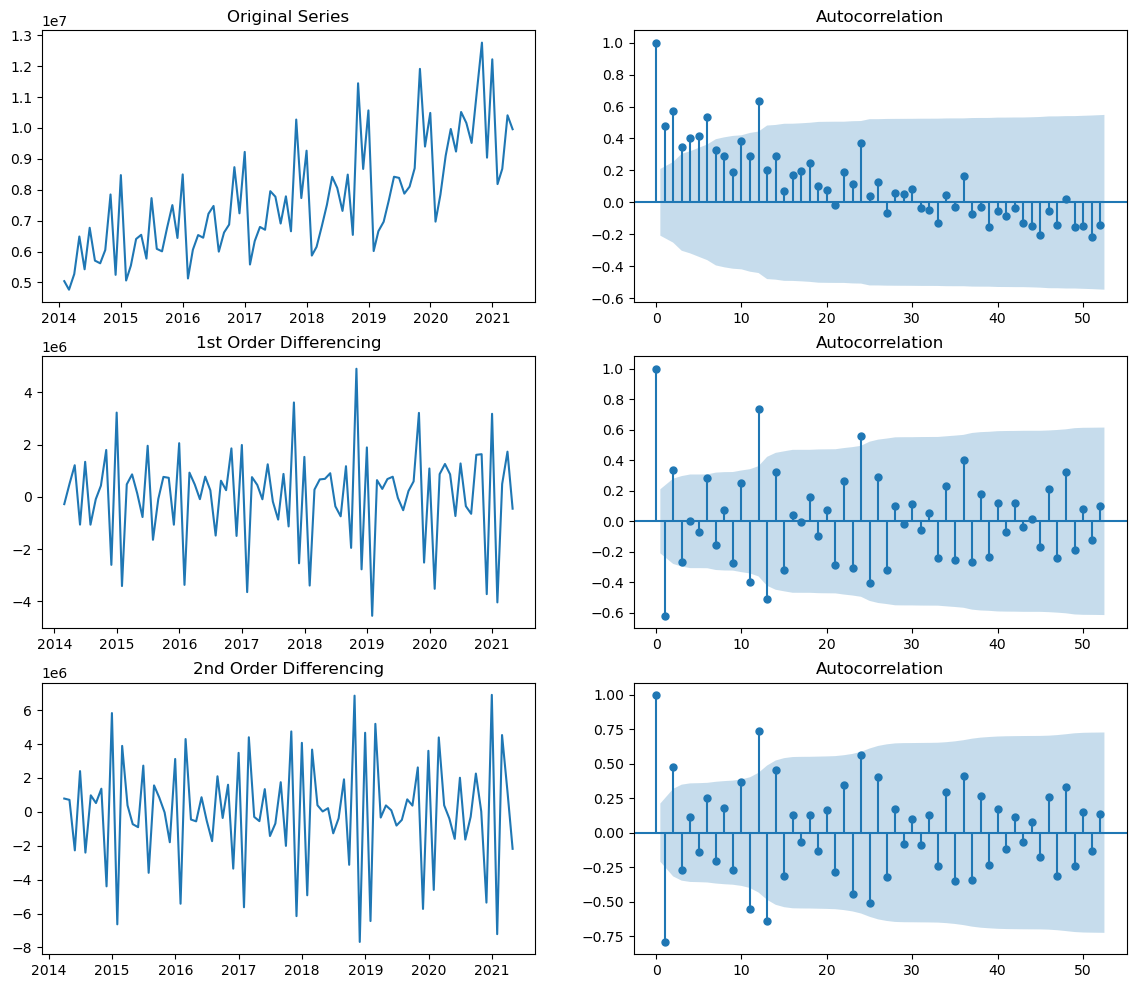

In [51]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(14,12))
axes[0, 0].plot(allstores.sales); axes[0, 0].set_title('Original Series')
plot_acf(allstores.sales, ax=axes[0, 1], lags=52)

# 1st Differencing
axes[1, 0].plot(allstores.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(allstores.sales.diff().dropna(), ax=axes[1, 1], lags=52)

# 2nd Differencing
axes[2, 0].plot(allstores.sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(allstores.sales.diff().diff().dropna(), ax=axes[2, 1], lags=52)


plt.show()

### Order of AR term (p)
- Check PACF after first-differencing
- Be conservative and set to AR(1)

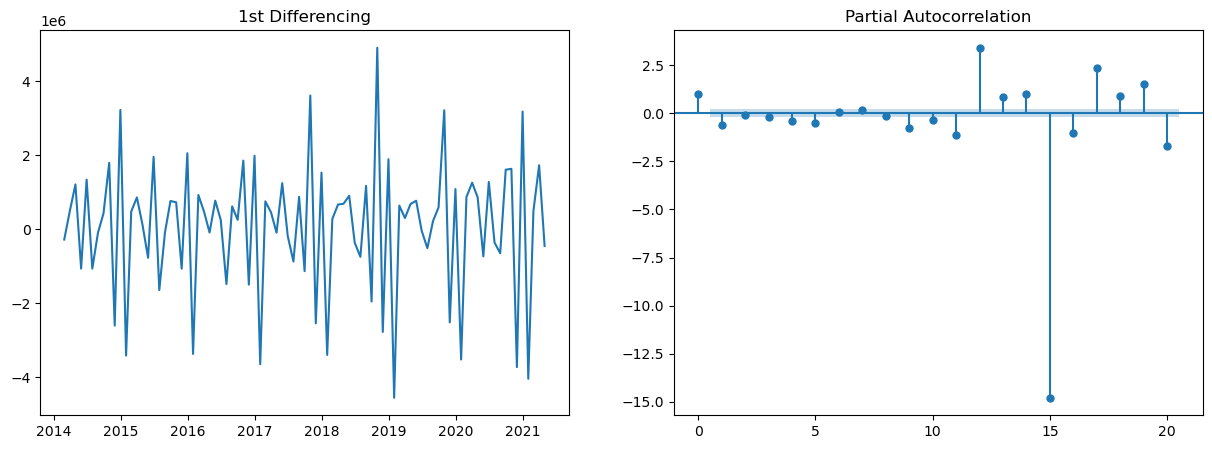

In [52]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(allstores.sales.diff()); axes[0].set_title('1st Differencing')
plot_pacf(allstores.sales.diff().dropna(), ax=axes[1])

plt.show()

### Oder of MA term (q)
- Lag 1 above significant level
- Set q = 1

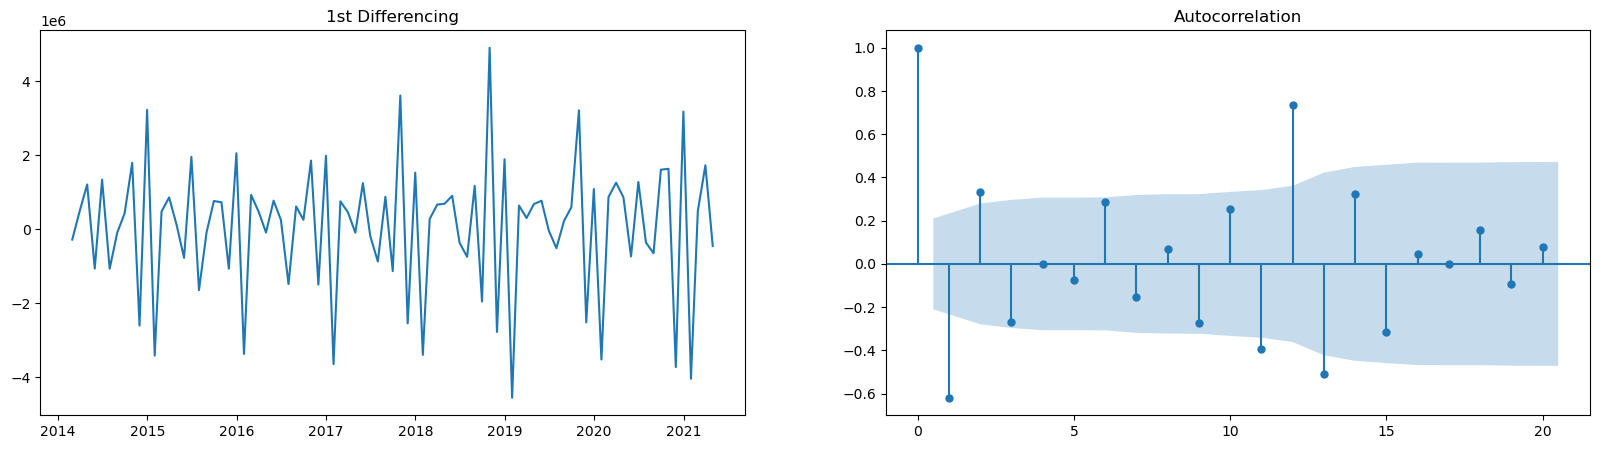

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(allstores.sales.diff()[0:100]); axes[0].set_title('1st Differencing')
plot_acf(allstores.sales.diff().dropna(), ax=axes[1])
plt.show()

### Create features

In [54]:
allstores = allstores[allstores.index.year>=2014]
def features(df):
    
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    #df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['dayofmonth'] = df_copy['date'].dt.day
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    
    features = df_copy[['quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    return features
features = features(allstores)

In [55]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(allstores.sales, exog=features, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   87
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1347.742
Method:                       css-mle   S.D. of innovations        1289747.361
Date:                Sat, 04 Sep 2021   AIC                           2715.485
Time:                        16:53:27   BIC                           2740.144
Sample:                    02-28-2014   HQIC                          2725.414
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.773e+07   1.39e+08     -0.701      0.483   -3.71e+08    1.75e+08
quarter       -1.123e+06   6.49e+05     -1.730      0.084    -2.4e+06    1.49e+05
month          2.479e+07   8.88e+06     

### Plot residual errors to check whether there are still patterns
- Looks fine
- Error appears normally distributed
- But there is still seasonality

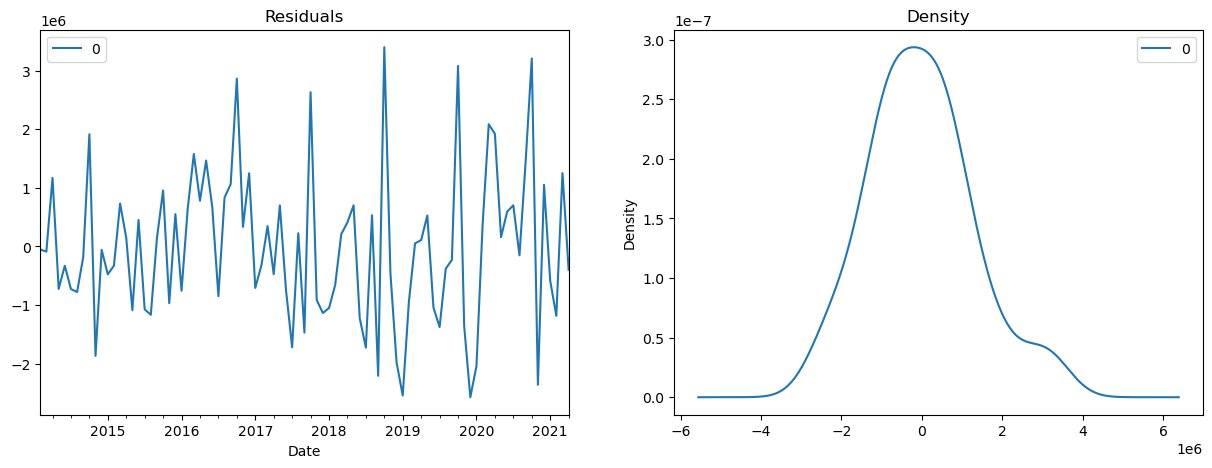

In [56]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

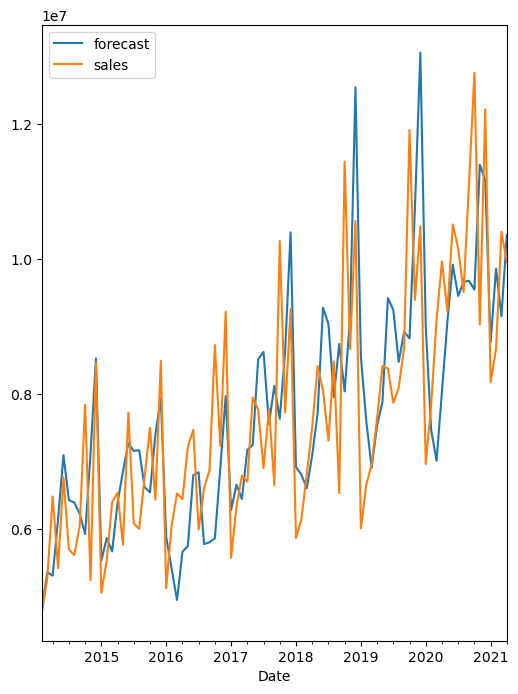

In [57]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# Try to fit a SARIMAX
- Fit stepwise auto-ARIMA

In [58]:
import pmdarima as pm

smodel = pm.auto_arima(allstores.sales, start_p=0, start_q=0,
                         test='adf',
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2269.504, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2268.687, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2256.219, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2253.016, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2252.037, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2253.145, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2254.745, Time=0.06 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=2254.549, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2254.570, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=2256.603, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=2254.212, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 1.056 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   88
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood               -1124.019
Date:                             Sat, 04 Sep 2021   AIC                           2252.037
Time:                                     16:53:30   BIC                           2256.672
Sample:                                          0   HQIC                          2253.888
                                              - 88                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3489      0.036     -9.826      0.000      -0.419      -0.279
sigma2      5.068e+11   3.74e-15   1.35e+26      0.000    5.07e+11    5.07e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.75   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               1.56   Skew:                             0.19
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.5e+41. Standard errors may be unstable.
"""

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(allstores.sales,order=(0,1,1), exogeneous=features,
              seasonal_order=(0,1,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

<AxesSubplot:xlabel='Date'>

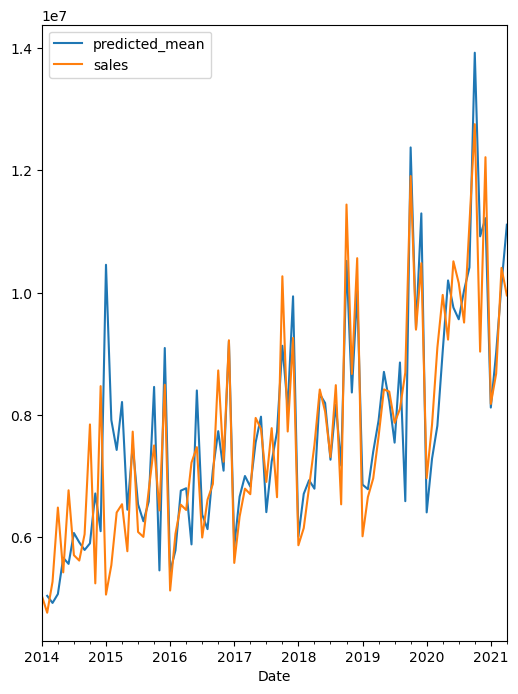

In [60]:
forecast = results.predict(dynamic=False)
forecast[1:].plot(legend=True)
allstores.sales.plot(legend=True)

# Import test data

In [61]:
most_recent_date = sales.Date.max()
most_recent_date
data_recent = pd.read_csv('data/Iowa_Liquor_Sales_recent.csv')
data_recent['Date'] = pd.to_datetime(data_recent['Date'], format='%m/%d/%Y', errors='ignore')

In [62]:
data_recent = data_recent[(data_recent.Date.dt.year>=2014) & (data_recent['Store Name'].str.contains('Hy-Vee'))]

In [63]:
test = data_recent[data_recent.Date>most_recent_date]
test = test.groupby([pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale (Dollars)','sum'))

In [64]:
plot_data = data_recent[data_recent['Store Name'].str.contains('Hy-Vee')].groupby([pd.Grouper(key='Date', freq='M')]).agg(sales=('Sale (Dollars)','sum'))

In [65]:
# Forecast
n_periods = len(test.index) + 1
fitted, CI = smodel.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(allstores.index[-1], periods = n_periods, freq='M')
fitted_series = pd.DataFrame({'predicted_sales':fitted}, index=pd.to_datetime(forecast_index))
fitted_series.index.rename('Date', inplace=True)
CI_L = pd.Series(CI[:, 0], index=forecast_index)
CI_H = pd.Series(CI[:, 1], index=forecast_index)

Text(0.5, 1.0, 'Predicted Sales (Thousands)')

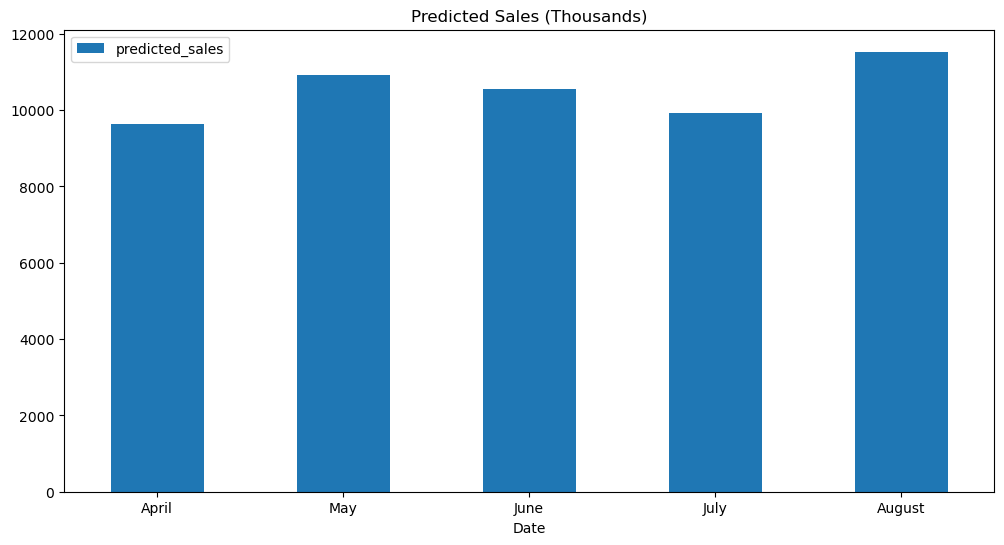

In [66]:
plot_series = fitted_series/10**3
plot_series.set_index(plot_series.index.month_name()).plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=360)
plt.title('Predicted Sales (Thousands)')

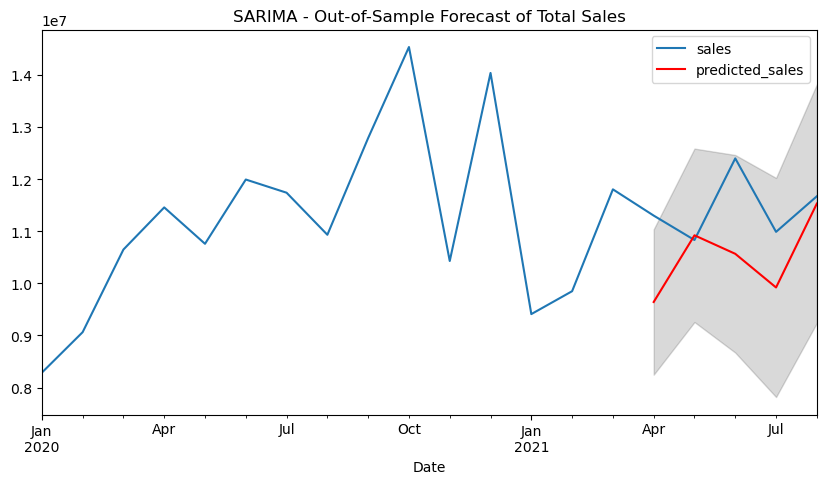

In [67]:
# Plot
f, ax = plt.subplots(figsize=(10,5))
plot_data[plot_data.index.year>=2020].sales.plot(ax=ax, legend=True)
fitted_series.plot(color='red', ax=ax)
plt.fill_between(CI_L.index, 
                 CI_L, 
                 CI_H, 
                 color='k', alpha=.15)

plt.title("SARIMA - Out-of-Sample Forecast of Total Sales")
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'April'),
  Text(1, 0, 'May'),
  Text(2, 0, 'June'),
  Text(3, 0, 'July'),
  Text(4, 0, 'August')])

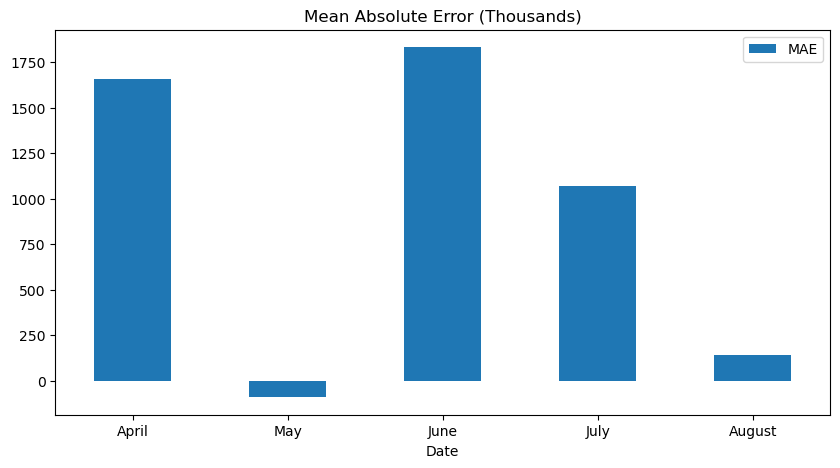

In [68]:
diff = pd.concat([plot_data, fitted_series], axis=1).dropna()
diff.index = diff.index.month_name()
diff['MAE'] = (diff['sales'] - diff['predicted_sales'])/10**3
diff.plot(kind = 'bar', y='MAE', title='Mean Absolute Error (Thousands)', figsize=(10,5))
plt.xticks(rotation=360)